# Exploratory Data Analysis on Yelp Dataset

## The goal of the project is to build an app that allows a user to find local resturants and eateries that specialize in a specific dish. This could be anything - bagels, pizza, chicken wings, tacos. We are looking to redefine what it means for a resturant to be "good", as many resturants specialize in certain dishes.

## The dataset can be found at https://www.yelp.com/dataset.

In [945]:
import numpy as np
import scipy
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import mplleaflet
from scipy.special import factorial as factorial
%matplotlib notebook
pd.set_option('display.max_columns', None)

### The first order of business is to load in the yelp data into our notebook. This requires first extracting all the json files from the compressed data set. Next, we find the two json files we are most interested in. 

### 'yelp_academic_dataset_business.json' holds all the business IDs, latitude and longitude coordinates, and names of the resturants.

### 'yelp_academic_dataset_review.json' is 6.33GB, and holds all the business ids and individual reviews of the resturant. In order to easily import in this large dataset, we split the data into chunks of 350000 reviews via "split -l 350000 yelp_academic_dataset_review.json, then import them all in while dropping catagories we don't want and are taking up memory, like 'review_id' and 'useful' catagories. 

In [481]:
business_data = pd.read_json('yelp_academic_dataset_business.json',lines=True)

In [485]:
data = pd.DataFrame()
names = ['xaa','xab','xac','xad','xae','xaf','xag','xah','xai','xaj','xak','xal','xam','xan','xao','xap', \
        'xaq','xar','xas','xat','xau','xav','xaw']
for filename in names:
    df = pd.read_json(filename,lines=True)
    df.drop('review_id', axis=1,inplace=True)
    df.drop('useful', axis=1,inplace=True)
    data = data.append(df)

### We next drop the data that we don't want form the business dataset, and filter by category so that we only are looking at businesses that provide some kind of food service

In [974]:
business_data.drop('review_count',axis=1,inplace=True)
business_data.drop('attributes',axis=1,inplace=True)
business_data = business_data[business_data['categories'].notna()]
food_business_data = business_data[business_data['categories'].str.contains('Resturants|Food|Bars|Ice Cream|Frozen Yogurt|Coffee|Tea|Diners',regex=True)]
Food_review_data = pd.merge(food_business_data,data,how='inner',on='business_id')
Food_review_data['text'] = Food_review_data['text'].str.lower()

In [975]:
Food_review_data.head()

,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,Parm
0,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2013-04-11 18:36:15,0,5,i love the empanadas from the empanadas house!...,eSQ3z93DlzkpXK_H6MFEMw,False
1,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2017-09-21 17:45:53,0,5,i ordered feta cheese and spinach empanadas an...,5So3uZiWDmow4eG8Va0WhQ,False
2,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2014-10-07 01:07:00,0,2,i went to the place on green st today. i went ...,Oh1CPqH5zBZfDEC_2ueTow,False
3,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2013-07-10 18:26:33,0,5,these empanadas are excellent- we are argentin...,vtqj_61x-cpLjrj1dBQTjQ,False
4,404 E Green St,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,4.5,IL,0,2019-05-07 03:12:10,0,5,these empanadas are huge and in my opinion bet...,aVWzh3hpLVUSVWSds75Sig,False


## We will restrict our analysis to the city of Toronto (for illustrative purposes)

In [976]:
Toronto = Food_review_data[Food_review_data['city'] == 'Toronto']

#### Before we go further, we want to build a baysean model for analysis. The goal is to find the posterior probability that given the data we collect, we will like the specific dish we are interested in. Consider as an example, tacos. 



# $P($good tacos$ \vert$review data$) = P($review data$ \vert$ good tacos$) *  P($good tacos$)  /  P($review data$)$
 
 
 
 
#### The probability of someone getting good tacos at the resturant is proportional to the likelihood of the data times the prior.
 
#### Our model for the likelihood will be to use a truncated version of the poisson distribution, where we restrict the values to be between 0 and 4 (corresponding stars 1 to 5) by dividing by a partition function Z

In [916]:
def Z(lam):
    return np.exp(-lam)*(1 + lam + lam**2/2 + lam**3/6 + lam**4/(6*4))

def poisson_prob(lam):
    vec = []
    for k in range(5):
        vec.append(lam**k * np.exp(-lam)/(Z(lam)*np.math.factorial(k)))
    return vec

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob

 ## We can interactivly examine how the probability distribution changes as we shift the lambda value

<IPython.core.display.Javascript object>


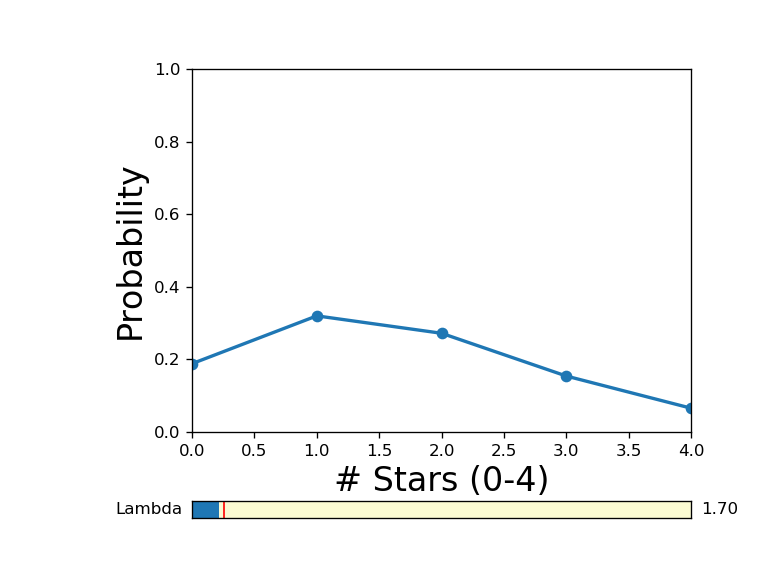

In [1066]:
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)


l, = plt.plot(poisson_prob(3), 'o-',lw=2)
plt.ylim([0,1])
ax.margins(x=0)

plt.xlabel('# Stars (0-4)',size=20)
plt.ylabel('Probability',size=20)
lamfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)


lam = Slider(lamfreq, 'Lambda', 0.1, 30.0, valinit=2, valstep=.1)



def update(val):
    lamval = lam.val
    l.set_ydata(poisson_prob(lamval))
    fig.canvas.draw_idle()


lam.on_changed(update)



plt.show()

### Say we are interested in finding the best tacos in Toronto. We would search the database for any mention of tacos, including mispellings, or related items, and return a list of the business indexes corresponding to these

In [977]:
businesses = Toronto[Toronto['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]['business_id'].value_counts().index.to_list()


### We can use a baysean model in order to sample from the posterior distribution. Here, we use the total resturant reviews in order to inform the prior distribution of the quality of the individual dish. This should make intutive sense - the better the resturant is, the more likely it will be that a specific dish is good. The worse a resturant is, the less likely. By using the total resturant information as the prior, we are biasing our results towards the general quality of the resturant. But if a specific dish is really good (or really bad), this will show up when we calculate the likelihood


# $P(\lambda_{taco} \vert $reviews$) \propto P($reviews of tacos$ \vert \lambda_{taco}) * P(\lambda_{all} \vert $reviews$)$

### Where the likelihood is defined as

# $P($reviews $\vert \lambda)$ = $\prod P(k_{stars}, \lambda)$ = $\prod \lambda^k e^{-\lambda}/Zk! $

### with k the number of stars awarded (from 0 to 4) and Z the normalization so the probability sums to 1

In [982]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob


    
    
    

### We can test this one just a single business to start

In [1010]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_resturant = pm.Uniform('lam_rest',0,10)
    y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
    lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5247.64draws/s]


### And see what the predicted taco score is ($\lambda_{taco}$ in the model). These plots give the probability density of specific parameters, along with the sampling paths for each parameter. This gives us far more information than just a mean and standard deviation, which could be used in further analysis to fine tune our scoring

<IPython.core.display.Javascript object>


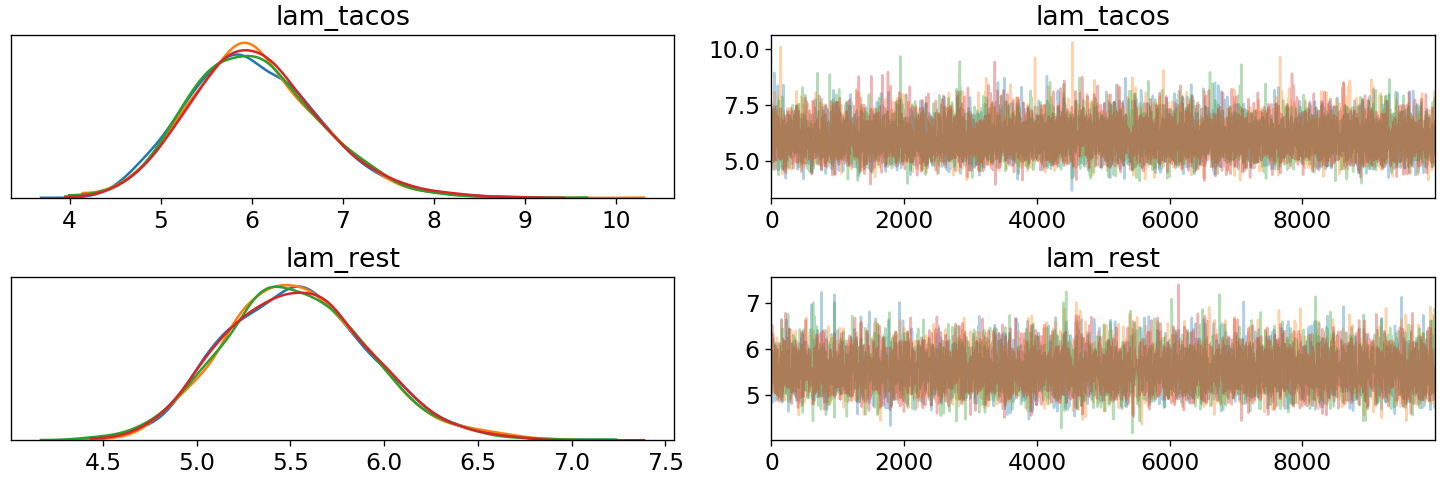

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2da3242e8>,
      dtype=object)

In [1011]:
pm.traceplot(trace)

In [1012]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_tacos,6.036,0.710,4.831,7.368,0.008,0.006,8483.0,8307.0,8682.0,8942.0,1.0
lam_rest,5.537,0.381,4.859,6.214,0.004,0.003,8203.0,8164.0,8272.0,8746.0,1.0


### A key question would be to see if this actually does any better at predicting how highly people will rate tacos. We can compare it to just the base model. Here, we actually see that the resturant in question scores higher for its tacos than it does overall! Those must be good tacos

### Another question is, would we just be better off using the taco only data?

In [1067]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_taco = pm.Uniform('lam_rest',0,10)
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 7884.50draws/s]


<IPython.core.display.Javascript object>


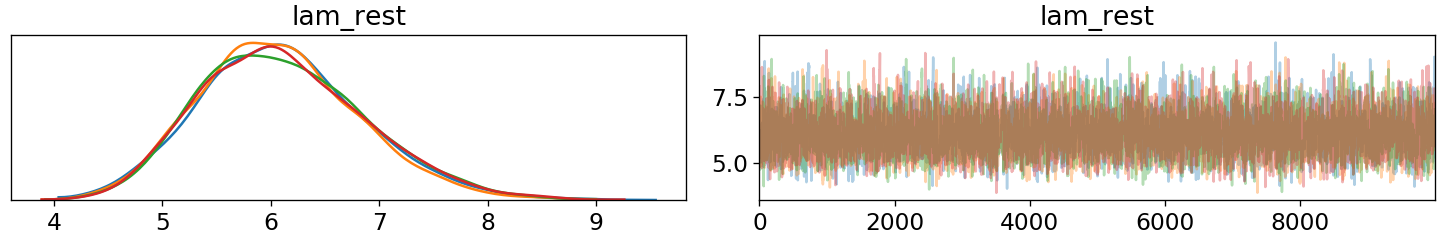

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e5240630>,
      dtype=object)

In [1068]:
pm.traceplot(trace)

In [1016]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_rest,6.097,0.741,4.806,7.471,0.008,0.006,7739.0,7552.0,8017.0,8239.0,1.0


### We can see here that the general resturant reviews, being not as good as the taco reviews, pulled the taco reviews down slightly. It's a minor effect, but would play a bigger role if we had a small number of taco reviews for the resturant

In [1022]:
len(tacostars)

6

### Now we get to the meat, which would be to take each business that mentions tacos, and review them, and then rank them by this taco score. We save all the taco scores in a dictonary for further use

In [1023]:

tacoscore_dict = {}

for business in businesses:
    sb = Toronto[Toronto['business_id'] == business]
    allstars = sb.stars_y.to_list() 
    fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]
    
    
    with pm.Model() as test_model:

        lam_resturant = pm.Uniform('la m_rest',0,10)
        y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
        lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
        y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(tacostars)-1))
   

    with test_model:
        step = pm.Metropolis()
        trace = pm.sample(10000,step=step,tune=5000)
        
    print('Business id =', business, '   Taco Score = ',az.summary(trace,varnames,credible_interval=.93).round(3)['mean'][0])
    tacoscore_dict.update({business : az.summary(trace,varnames,credible_interval=.93).round(3)['mean'][0]})

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5844.54draws/s]


Business id = MS-hfug4QDXqb_Mws3qlzA    Taco Score =  2.613


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6167.23draws/s]


Business id = VRwT0pscR5vESCrAnUpNwQ    Taco Score =  2.798


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5863.82draws/s]


Business id = N93EYZy9R0sdlEvubu94ig    Taco Score =  2.92


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5835.06draws/s]


Business id = O_UC_izJXcAmkm6HlEyGSA    Taco Score =  2.718


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5135.45draws/s]


Business id = gEv1Og5uGDLw9HkbKSGUZw    Taco Score =  2.538


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4697.07draws/s]


Business id = Yv4P4qUwd7F-qQ4Y4eD1JQ    Taco Score =  2.588


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4860.92draws/s]


Business id = 4u1iOihWOVkgNTId927fHg    Taco Score =  2.486


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4999.44draws/s]


Business id = mES9E5K4HbYoPFXGv0pUuw    Taco Score =  2.744


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4709.50draws/s]


Business id = IhM1UBvAMM5Fia4f_v1wdQ    Taco Score =  3.137


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3425.37draws/s]


Business id = SjgeuBlgKER9yegpoxT99w    Taco Score =  2.743


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3760.36draws/s]


Business id = LBQD0H2109oltJNF1raLWA    Taco Score =  2.826


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2990.72draws/s]


Business id = LBHbyID7tcaGszznHtnCrw    Taco Score =  2.631


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3138.43draws/s]


Business id = K6MBwTYeuLH0VsTVCLVgxg    Taco Score =  2.727


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3469.05draws/s]


Business id = 1K4qrnfyzKzGgJPBEcJaNQ    Taco Score =  2.65


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4220.40draws/s]


Business id = pZ1quwXnYozLIZIVABojhw    Taco Score =  2.84


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3737.38draws/s]


Business id = DXl9YviWyzAwMeUtrBPW7w    Taco Score =  2.381


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3117.38draws/s]


Business id = b7wUWVV01xaa7E0FUNMDiw    Taco Score =  2.854


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3125.81draws/s]


Business id = 33IS-0QBNwRC8cXnHABpbg    Taco Score =  2.617


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2780.85draws/s]


Business id = tJcpzXzykNSLuzWwa1JQUw    Taco Score =  2.382


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3194.42draws/s]


Business id = tuTAKHUm7ErDRZ2Yll8LzQ    Taco Score =  3.03


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3471.85draws/s]


Business id = sPPh1LJllyr5jUpKFTxxag    Taco Score =  2.674


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3234.12draws/s]


Business id = _5izyrn1qV0uyec65UsdIA    Taco Score =  2.655


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3510.83draws/s]


Business id = d4P7boUqiA2pR59jOlzYLA    Taco Score =  2.728


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2621.51draws/s]


Business id = q8MUVVuQpfR6v0HBHmAFxw    Taco Score =  2.583


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3180.39draws/s]


Business id = jVefoZbu5VF80CCB1Q2MaA    Taco Score =  2.588


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3227.97draws/s]


Business id = yY3jNsrpCyKTqQuRuLV8gw    Taco Score =  2.657


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3160.98draws/s]


Business id = gOBxVkHpqtjRRxHBIrpnMA    Taco Score =  2.524


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3100.65draws/s]


Business id = QFPS9JBNdOOHVP0C3pSslw    Taco Score =  2.538


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2702.96draws/s]


Business id = Nz44ccUso3nq5S2OlQHNlA    Taco Score =  2.78


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:26<00:00, 2279.64draws/s]


Business id = O-uIEuv7JLUHajkemx_sVw    Taco Score =  2.717


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3126.18draws/s]


Business id = zZHKHyz079fgX3sMskDKSg    Taco Score =  2.344


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2585.93draws/s]


Business id = e41TP5cXZqSrz50xCBJqZw    Taco Score =  2.777


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2754.89draws/s]


Business id = uCDVOidGLpD-Q7_y82nx2g    Taco Score =  2.468


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3193.50draws/s]


Business id = eYeFOcNJO2iTNPCPi8XAxw    Taco Score =  2.915


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3579.30draws/s]


Business id = 73_UT7fZ7mzXcguX8-oSuQ    Taco Score =  2.444


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3299.44draws/s]


Business id = hkZh4tAa2oJ34i8hxej6Zg    Taco Score =  2.645


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3753.20draws/s]


Business id = lOKgoQtMhnlf6hWvrOiMtQ    Taco Score =  2.57


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3658.84draws/s]


Business id = 0uMK11Hq5pTLyxLE1lWRzQ    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4262.79draws/s]


Business id = gHmkE8VoNjJZDLVdTpJPOw    Taco Score =  2.252


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4283.26draws/s]


Business id = nemcwBBzPuTbP9oKF9t_Jw    Taco Score =  2.287


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4388.64draws/s]


Business id = klu0zF1rWAoNAhKPsFyUog    Taco Score =  2.539


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4462.95draws/s]


Business id = ejKXczjEkm1gzyRdblQm8w    Taco Score =  2.676


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4514.55draws/s]


Business id = 1W_gZM_uuEvJqapbIl6z9Q    Taco Score =  2.848


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4332.37draws/s]


Business id = n_4PTgvjsKc74u8AwXOfAQ    Taco Score =  2.679


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4543.87draws/s]


Business id = 4MQaqhBUJCpghGukSWNq7w    Taco Score =  2.505


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4475.55draws/s]


Business id = QrTg1ZaKcaJj2fzXQmHFXQ    Taco Score =  2.358


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3647.32draws/s]


Business id = dRjU-uxMeInyYgBb61Ap7A    Taco Score =  2.994


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3682.74draws/s]


Business id = LkgqiRF3LaZCVQmDFC0AaA    Taco Score =  1.955


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3164.52draws/s]


Business id = rxA9c0_XObabVL1WCTA4FA    Taco Score =  2.549


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:24<00:00, 2451.65draws/s]


Business id = AUv2UoAAi7VASJ6VK5lOlw    Taco Score =  2.912


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3353.67draws/s]


Business id = exysqt4RqxkF9I8Z2NEUsQ    Taco Score =  2.678


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3388.64draws/s]


Business id = uQDVjBcG6t3t-5hSQnZ4lQ    Taco Score =  2.105


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4086.52draws/s]


Business id = Py97oycFokZ296KJ2Pe-hQ    Taco Score =  2.36


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3688.82draws/s]


Business id = PPCEx65Lm121Hw5yQhM_Zw    Taco Score =  2.428


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3088.70draws/s]


Business id = s6Ds2KXvfYXkucWl6li1UA    Taco Score =  2.611


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3314.33draws/s]


Business id = HkHTdTvzbn-bmeQv_-2u0Q    Taco Score =  2.622


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4211.31draws/s]


Business id = -OxDX2fPQLYi6ChW2Z6xxQ    Taco Score =  2.608


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3633.46draws/s]


Business id = 7F0ccIsqZSaqi1r7SB4nfQ    Taco Score =  2.442


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3075.33draws/s]


Business id = wSojc-y-d7MWiGWdy8deCg    Taco Score =  2.707


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3604.55draws/s]


Business id = sgj0sLFaZZUrRG0pzWnZKw    Taco Score =  3.014


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3346.87draws/s]


Business id = JG9UpsFR6hrqQqsKh_RyaQ    Taco Score =  2.668


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3613.81draws/s]


Business id = zeOJYl5UW4D5u3Vcj6QAoA    Taco Score =  2.96


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2826.21draws/s]


Business id = fQwB9Z98YEhkJit7c3z51A    Taco Score =  2.703


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3103.35draws/s]


Business id = qztZIyt2BMSKfX052OgKXQ    Taco Score =  2.223


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3385.02draws/s]


Business id = abWt3B-dvJ1oVj83ebYoyg    Taco Score =  2.866


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4065.35draws/s]


Business id = umxN12ok_qOB4qru0qmx6g    Taco Score =  2.062


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3164.46draws/s]


Business id = OSF8Iy5Xq-hAN4-zhDVS4w    Taco Score =  2.475


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3513.67draws/s]


Business id = 28adZ4lsuUeVB2aWzohK9g    Taco Score =  2.547


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3922.32draws/s]


Business id = 826djy6K_9Fp0ptqJ2_Yag    Taco Score =  2.488


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3586.74draws/s]


Business id = bYGn37k0KgleABKMWgjnMw    Taco Score =  2.426


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3211.04draws/s]


Business id = K6XIGkyk7-fuOQtA8i7p6A    Taco Score =  2.469


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2727.34draws/s]


Business id = DQ6TonJZAofhwI56FvNjoA    Taco Score =  2.778


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3771.54draws/s]


Business id = xS5Tg_H9GBEyOTWl9JwhvA    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4202.73draws/s]


Business id = cIX8h9_IrzU_-4TGXGM0fQ    Taco Score =  2.806


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3599.90draws/s]


Business id = DIVF4oo86EGupm5CC60sZg    Taco Score =  2.421


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:24<00:00, 2402.97draws/s]


Business id = 0cpLF0LFQHHRFNlL0iy_Aw    Taco Score =  2.621


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3298.04draws/s]


Business id = -aYwA_ar653bmiCLJNzXFw    Taco Score =  2.641


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3605.06draws/s]


Business id = 8D4VMtrHQ5qBnRhYycq8IA    Taco Score =  2.532


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3772.61draws/s]


Business id = Fgje0saJKZkCByBMj4SlhA    Taco Score =  2.89


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3451.84draws/s]


Business id = 1I3PnP5FSkur8AXp6izLOw    Taco Score =  2.622


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3539.79draws/s]


Business id = -iyyNb7ygeWB5kob28H8eA    Taco Score =  2.564


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3670.94draws/s]


Business id = zC-RnKVTlGEBmzCngDzp0Q    Taco Score =  2.482


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3584.72draws/s]


Business id = Tts6148XS4zIMpWPq3dmAA    Taco Score =  2.463


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3526.50draws/s]


Business id = 8ySvFNHBGHnVaQ3XwOuFqg    Taco Score =  2.696


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3440.65draws/s]


Business id = QPVc_HQYcQicsowyeMPpkA    Taco Score =  2.735


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:28<00:00, 2089.09draws/s]


Business id = SZpzMUdhh1xu2qlegzSyLg    Taco Score =  2.123


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2993.79draws/s]


Business id = goihA0c0gTfhNKmgBOHYBA    Taco Score =  2.407


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3037.66draws/s]


Business id = sYSlKRCWmVeQr1hA6-WUzw    Taco Score =  2.621


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2855.44draws/s]


Business id = svijhRN0hWIHfKb421D1Tg    Taco Score =  2.573


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3299.27draws/s]


Business id = URvh6DgFyA-d6Z7OVKxczg    Taco Score =  2.759


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3456.83draws/s]


Business id = StjUke9uj6T6qB4hpyzMMA    Taco Score =  2.577


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3261.05draws/s]


Business id = DYGCzsHi7pT4AAe8kh5Dug    Taco Score =  2.431


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3438.69draws/s]


Business id = GQSmxqRi_s9U9qd5gHLKAw    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3174.22draws/s]


Business id = 7ppWunvrIURnEZi5nUB_7g    Taco Score =  2.598


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:26<00:00, 2256.94draws/s]


Business id = 2auigv5pF08RjJ8CL1dIVw    Taco Score =  2.346


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:25<00:00, 2315.19draws/s]


Business id = IgQ8lSds3AgLFQsYsshUHQ    Taco Score =  2.485


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2501.31draws/s]


Business id = TL4KaVKtHJfDeHrAjUFdeQ    Taco Score =  2.755


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3137.84draws/s]


Business id = ZBFfY_WLbp19sADTZ_LRMg    Taco Score =  2.695


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3537.61draws/s]


Business id = C7XhjijIGwMx8EiAbu5CMA    Taco Score =  2.612


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3593.90draws/s]


Business id = FCMRBcvrwN01eT6WRaTC6A    Taco Score =  2.598


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3696.99draws/s]


Business id = bSLIrhdxrxuz3p_nz1iLpg    Taco Score =  2.421


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3244.96draws/s]


Business id = TKKX9bllRBMzp0NYr441PQ    Taco Score =  2.802


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2693.94draws/s]


Business id = ynmTXY9yJDiNkO4HUmxRSQ    Taco Score =  2.404


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2639.70draws/s]


Business id = IBZ6e3P0OqcPXVjvGlpueQ    Taco Score =  2.56


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3713.31draws/s]


Business id = 6CmrVgQVGozVwcOK6-KgNA    Taco Score =  2.322


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3240.08draws/s]


Business id = VDgcNqOAf9kzvyrkYWxvvQ    Taco Score =  2.375


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3057.44draws/s]


Business id = MT-lkIacLNyC7KF2dY997A    Taco Score =  2.299


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2957.25draws/s]


Business id = G2unb0jq9lTutaVS9r1Jyw    Taco Score =  2.481


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2818.12draws/s]


Business id = N_2yEZ41g9zDW_gWArFiHw    Taco Score =  2.405


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3825.76draws/s]


Business id = y-Iw6dZflNix4BdwIyTNGA    Taco Score =  2.783


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3965.31draws/s]


Business id = xpJEBXTCQh5Ib8BJrjt9Bg    Taco Score =  2.399


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4033.65draws/s]


Business id = bgOgbr7ocyfYafqUAaR0WA    Taco Score =  2.548


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3904.26draws/s]


Business id = ghaj1MZzPW1qXYCZWfoTTw    Taco Score =  2.718


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4174.36draws/s]


Business id = Ku3ME-bW3zINVJiP9zkOEg    Taco Score =  3.067


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4011.67draws/s]


Business id = s-9ZfWtECJLMnND12t6RMA    Taco Score =  2.717


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4141.24draws/s]


Business id = I5lmLFi76ru5Ky_amax8lQ    Taco Score =  2.662


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3888.35draws/s]


Business id = uN2oZDJGO078ExbbV_DGmA    Taco Score =  2.019


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3971.87draws/s]


Business id = 3FVpx9ksZLgOrYy1I05Ypg    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3589.86draws/s]


Business id = HFPovXxiMQ451N80-E-vyQ    Taco Score =  2.906


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3894.51draws/s]


Business id = SyDQXZVP2eRxirFmsD-p1A    Taco Score =  2.85


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3988.57draws/s]


Business id = aAYl1-tsvP9Kzs7YESi8Rg    Taco Score =  2.633


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4050.80draws/s]


Business id = VN5D_k5i2MLyliuGAiCOxQ    Taco Score =  2.406


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4110.27draws/s]


Business id = 2DR272SEywpXSfFgofKQSg    Taco Score =  2.354


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4154.65draws/s]


Business id = aO0qeGIOzEexYeCRr_O5sw    Taco Score =  2.45


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4103.96draws/s]


Business id = Qa4eXuZ1IFPwnVXJcpZWtw    Taco Score =  2.484


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4345.44draws/s]


Business id = LYb2yOaVk4Ka_N4qt0gFsQ    Taco Score =  2.491


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4109.35draws/s]


Business id = KpFgHrxoVOiwfpR0f5KXUA    Taco Score =  2.716


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4219.11draws/s]


Business id = Q2ZNaN3p8s_-XXjBWyY2qA    Taco Score =  2.589


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4183.14draws/s]


Business id = 1baM3j-bqzUJaqRM2z2PtA    Taco Score =  2.583


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4209.94draws/s]


Business id = ycZRyUBfitNEkV_AKTnjYg    Taco Score =  2.146


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4125.78draws/s]


Business id = CmOFu9WDV0GsxD6QyFV4Iw    Taco Score =  2.221


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4329.20draws/s]


Business id = f2cLqQutMDaxEsZGtk9TWw    Taco Score =  2.675


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4376.58draws/s]


Business id = q7MorRPzU_J-iekeDKUKgw    Taco Score =  2.775


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4153.45draws/s]


Business id = ivbMuKOwwX2B70gFggzT-g    Taco Score =  2.561


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4247.24draws/s]


Business id = cUxsG0rgpE18dMyvyw8Gdg    Taco Score =  2.283


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4100.95draws/s]


Business id = BxCzy1WOVxOrr_G7V4BIvg    Taco Score =  2.67


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4062.00draws/s]


Business id = QhAmKLX_0AgQe5HLxode9Q    Taco Score =  2.809


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3351.74draws/s]


Business id = ywPaE5Ai8SK8TeUoeMgJ6Q    Taco Score =  2.2


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3601.23draws/s]


Business id = tHjRafhkBKYDdlKAD7Dntg    Taco Score =  2.725


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3400.59draws/s]


Business id = p8H1RF75ByAEoGnzfNwVGA    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3107.62draws/s]


Business id = A1ffpWV8pKHQkjoNZhBbnw    Taco Score =  2.74


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3398.14draws/s]


Business id = EJmiKQKlWfY-0iVlya7FOQ    Taco Score =  2.119


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2922.07draws/s]


Business id = GZ12skjXwuMuH3LidRN-mA    Taco Score =  2.471


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:27<00:00, 2208.57draws/s]


Business id = 4wtqTzXPPp_6vBfFQKiTGQ    Taco Score =  2.17


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2891.46draws/s]


Business id = Q0fQ5FRT0ug80Vk9XV3iYw    Taco Score =  2.985


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3894.59draws/s]


Business id = bZgfnQtLXly82_XmLBqOwQ    Taco Score =  2.269


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4417.09draws/s]


Business id = FML0YqZ7dLBBC3Suap4_4Q    Taco Score =  2.714


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3912.36draws/s]


Business id = c_FTil8s5PS2l_YJDQAXhA    Taco Score =  2.738


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3527.54draws/s]


Business id = 4SyAKQevPuB4punANp41-Q    Taco Score =  2.558


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4612.33draws/s]


Business id = W9oSegtf7DYNryRWguaUPg    Taco Score =  2.194


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5091.67draws/s]


Business id = ByR685ThcDqQ_bb4A1oj_Q    Taco Score =  2.946


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4261.23draws/s]


Business id = bNO_c8Gka2Rkwaub3qVAMQ    Taco Score =  2.43


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3993.49draws/s]


Business id = md3DvLQyWlp3RJIFl4qnPA    Taco Score =  2.037


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4005.03draws/s]


Business id = JwHp9IMXe56eTc5pjofJgQ    Taco Score =  2.688


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3657.17draws/s]


Business id = sjxNnjKwWn7H6QcsAhhXww    Taco Score =  2.368


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4162.24draws/s]


Business id = 4eqHtgdXEPG6V-Jzy0MhKw    Taco Score =  2.5


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4125.03draws/s]


Business id = 1_qcKXfm8H8zecygxHjeWw    Taco Score =  2.03


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4619.03draws/s]


Business id = rSiSZlTzHi4Ox_rFHe9CdA    Taco Score =  2.408


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4528.48draws/s]


Business id = 7sTYnCrftf2IG0-4x3CDeA    Taco Score =  2.449


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3478.40draws/s]


Business id = GKEl7LNGUqJiQWNQ0vpH8Q    Taco Score =  2.29


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4459.25draws/s]


Business id = M_fzy4_KslKoXeyZ022Z8g    Taco Score =  2.544


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4800.70draws/s]


Business id = 3uIXuw878fNjxZ2Li1diFg    Taco Score =  2.633


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3721.49draws/s]


Business id = kaW97gZXyGMdkedZNdQuew    Taco Score =  2.615


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4339.21draws/s]


Business id = 2Wff1lKhXu56Rdsf0omDGA    Taco Score =  2.46


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4704.26draws/s]


Business id = nb2Bpt5uGGZvNhnkEGMnpw    Taco Score =  3.017


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4761.27draws/s]


Business id = HSPMT3m9OOD4ypMO4wwOdg    Taco Score =  2.718


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4718.31draws/s]


Business id = eoG9zP7xxsDHVM0kJYrvkw    Taco Score =  2.696


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4730.26draws/s]


Business id = wcR9Vbwn2EmlSeV7uBUIsA    Taco Score =  2.375


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4862.53draws/s]


Business id = w-Q_ZVaRk3_6SGI2_zIR3g    Taco Score =  2.677


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4657.77draws/s]


Business id = oM4nwtYDw5Ml-hrJdgv8TA    Taco Score =  2.517


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4540.06draws/s]


Business id = 5N8R7ALESZ30EoAzVJtabw    Taco Score =  2.597


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4709.58draws/s]


Business id = a911y0BuV1rjHXkXlFm3Ig    Taco Score =  2.619


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3742.81draws/s]


Business id = zA3LquAMUK4j-tMUqUOiWg    Taco Score =  2.635


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3424.97draws/s]


Business id = -6sE5v4OrVGmWxdIrbs-RQ    Taco Score =  2.855


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3342.74draws/s]


Business id = kAjCI0-7igmzWdsXbOuYWQ    Taco Score =  2.215


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3423.26draws/s]


Business id = CcZG-ITBPSDDTxFHVZEOeg    Taco Score =  2.533


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3410.96draws/s]


Business id = c9eUmcKIfgDaF-WUv4ILVw    Taco Score =  2.305


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3603.15draws/s]


Business id = Eox_Qq74oaFZ-YjthpHhBw    Taco Score =  2.469


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3966.09draws/s]


Business id = NqOmAGGEed-W4eXWlMd0Bw    Taco Score =  2.478


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4046.78draws/s]


Business id = BN7KeClLq8DR-crgAImpcQ    Taco Score =  2.397


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3859.68draws/s]


Business id = AsPW2a72MNVuV8LTDDNyDQ    Taco Score =  2.513


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4124.86draws/s]


Business id = nrq5H3LZicjMG0wv7gy08g    Taco Score =  2.852


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4388.82draws/s]


Business id = JgaQFKxW-Bnfc7r5EJZhSQ    Taco Score =  1.965


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4937.95draws/s]


Business id = RWYQMss0RzbtDGGwRI3iaQ    Taco Score =  2.077


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4894.72draws/s]


Business id = XxnnXca0ODSmMpS5QrWlCg    Taco Score =  1.812


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4960.88draws/s]


Business id = drNhiiDfuWAbuGcK3or8IA    Taco Score =  2.395


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4944.22draws/s]


Business id = bGuxRBRKv7i1BKKfGbjxEw    Taco Score =  2.575


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4880.35draws/s]


Business id = euAfN3ilf8ySF4p9I-xyvg    Taco Score =  2.212


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4874.76draws/s]


Business id = eQCYur0033RkZdh5VjbF8A    Taco Score =  2.437


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4717.71draws/s]


Business id = BpJlQ1yJKSL_hMSlm1dKHQ    Taco Score =  2.363


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4777.75draws/s]


Business id = VnvRZia9M18-IUarfdnYfA    Taco Score =  2.379


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4632.24draws/s]


Business id = 47wBHgBwQ8_70sjmXow_1g    Taco Score =  3.14


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2785.93draws/s]


Business id = dT70QOjn-o9pkdSAAPdSWQ    Taco Score =  2.137


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3159.81draws/s]


Business id = ofw8aDSEg1HoQdmCgvLtaQ    Taco Score =  3.003


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3440.16draws/s]


Business id = HGRPUfppQmMXsfHYdD-AGg    Taco Score =  2.683


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3903.25draws/s]


Business id = yB6EN23QuMuzHyobJ6pBbg    Taco Score =  2.146


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4794.59draws/s]


Business id = OZN43HzSTJVKBAKXmXxAjw    Taco Score =  2.667


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4593.12draws/s]


Business id = hBqp4v9iKsM-6i56v0MBuQ    Taco Score =  2.027


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4921.17draws/s]


Business id = ZP_1K8uC-YGbdPQ0KfNJog    Taco Score =  2.826


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4976.72draws/s]


Business id = swM_9CXxkvxEk3fDkjA6PQ    Taco Score =  2.662


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4969.21draws/s]


Business id = KpgqaCEqXmxSc4ejb29KHw    Taco Score =  2.808


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4091.30draws/s]


Business id = pwXkM4yHrcojgnx2qJQt7A    Taco Score =  2.005


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3524.59draws/s]


Business id = pOEL97ld-FJMKO8Ki8JmYg    Taco Score =  2.263


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3344.85draws/s]


Business id = NrJSy3dgcXErFtOKGREmnw    Taco Score =  2.762


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4391.85draws/s]


Business id = CN5nuUQod0f8g3oh99qq0w    Taco Score =  2.782


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3868.67draws/s]


Business id = ryyptYnhb8n94NnEF_MRnQ    Taco Score =  2.508


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4634.45draws/s]


Business id = tZt9k3BZ0AaXT4XCOEeRwQ    Taco Score =  2.356


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4633.89draws/s]


Business id = QNAookOK29CloYbO11xWWg    Taco Score =  2.662


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3603.75draws/s]


Business id = iQbvBT1PY1FQdxGUC30nZQ    Taco Score =  1.753


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4567.76draws/s]


Business id = Io1WmI1cUc8QaUVxSx1KuA    Taco Score =  2.683


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5062.04draws/s]


Business id = LAqGKns1zklhNF-tbbSCEQ    Taco Score =  2.541


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3767.70draws/s]


Business id = m6NIoPM9vhhevZBdF79R1A    Taco Score =  2.399


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3783.60draws/s]


Business id = sHXIiGercy22UVpwMMmYng    Taco Score =  2.212


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3557.12draws/s]


Business id = Dxp9SElV1f5MwPxIun_47w    Taco Score =  2.191


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4704.83draws/s]


Business id = Z8O-Svr6gE_Ie1HVy1I8DQ    Taco Score =  2.397


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4221.98draws/s]


Business id = AMug9zQbMrdw7aM1EaMDsw    Taco Score =  2.633


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3606.80draws/s]


Business id = mYco0c2HXIGMs-XdrNnDjA    Taco Score =  2.265


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3278.41draws/s]


Business id = dBgsdUgEdB8vqCREi9QfTA    Taco Score =  2.413


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2856.90draws/s]


Business id = RYGTF_2UlcdwDYZqL8duQQ    Taco Score =  2.704


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3414.09draws/s]


Business id = j8oKeBN7GYt2iOg5xmawJw    Taco Score =  2.849


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3257.64draws/s]


Business id = zdxOrKy1GGyQcchr0qZvnQ    Taco Score =  2.716


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3058.00draws/s]


Business id = zyw5DjrRks7a8OhmBsgCQQ    Taco Score =  2.348


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3771.28draws/s]


Business id = r48H_sNUGmcRGX1LsEc2mg    Taco Score =  2.316


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3606.38draws/s]


Business id = 3tiEjjBtdfV5_npPNzs0Cg    Taco Score =  2.539


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3018.28draws/s]


Business id = s-S2xzhmyWw7TUDet7WBnQ    Taco Score =  2.781


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3323.32draws/s]


Business id = GY2VyNBxX5H_8kilGCAjUA    Taco Score =  2.38


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4220.53draws/s]


Business id = JmZj7wzAJ7_4ksjG9WXdqw    Taco Score =  2.569


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3745.68draws/s]


Business id = dUePqUU5pROUEPiWBau72A    Taco Score =  2.263


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3452.12draws/s]


Business id = 5dSrlAsETYORRe4nYmxDZA    Taco Score =  2.343


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4208.36draws/s]


Business id = 8bskEwLJsPe2X3Avixab-Q    Taco Score =  2.789


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3202.44draws/s]


Business id = UOhH3rN9pN6LKx_FngkNtg    Taco Score =  2.379


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2965.20draws/s]


Business id = e6UDJBEIoXBbnXtdwkqIGA    Taco Score =  2.467


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3913.11draws/s]


Business id = AOyMxWRZg_5dDMaYTTBwdw    Taco Score =  2.807


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3053.24draws/s]


Business id = AcCZJpxiPqyzKFjlwlwd0Q    Taco Score =  2.504


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3318.33draws/s]


Business id = fC-fYPMzE7_CAWSBNMntxg    Taco Score =  1.991


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3440.00draws/s]


Business id = C3rH8u6P3wFH95AH8SeNmw    Taco Score =  2.507


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2897.23draws/s]


Business id = yjlrIZ5FtsiYFIn3xiaNIw    Taco Score =  2.613


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3062.19draws/s]


Business id = kOFDVcnj-8fd3doIpCQ06A    Taco Score =  2.741


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3839.09draws/s]


Business id = A1Xgwse4245M7bTglE5jXA    Taco Score =  2.421


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3665.20draws/s]


Business id = KTQnkLLKTEJfYEy_NT05OA    Taco Score =  2.501


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3167.73draws/s]


Business id = 3xUoXuEgJhHlSgBsSfKeCQ    Taco Score =  2.503


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3584.96draws/s]


Business id = OUB81Dpb6m7HjW4ZmeSlmw    Taco Score =  2.38


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3370.07draws/s]


Business id = JXPbwc0LkEJxQstYgb84Zw    Taco Score =  2.881


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3691.39draws/s]


Business id = wpQsmMvdhefqIlxvRt_Jbg    Taco Score =  2.328


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3017.15draws/s]


Business id = sXg2NCfiCqK_X_4R5NK_jQ    Taco Score =  2.938


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2812.77draws/s]


Business id = PiGd6nJRhbU3s7nP7XOE0g    Taco Score =  2.461


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3272.37draws/s]


Business id = gy5pr5bFAjOL5rERSdMCLg    Taco Score =  2.823


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4407.54draws/s]


Business id = 23Dg53bT4WIJDK26WPR7vQ    Taco Score =  2.58


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3927.64draws/s]


Business id = cQ4R6L475z3Ogkr2-5pKxA    Taco Score =  2.743


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3386.51draws/s]


Business id = KS_d3F_eIA6iTo6Wtj2O_w    Taco Score =  2.476


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3111.81draws/s]


Business id = kiyTiW-2Ba65O3uAMaagTA    Taco Score =  2.124


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3570.60draws/s]


Business id = 5Qoq8cif3nMCQUN-urH8YA    Taco Score =  2.201


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2855.34draws/s]


Business id = xFr7WKEyRRURjQmYXEk-LA    Taco Score =  2.148


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2981.60draws/s]


Business id = nKeGPmH5dYNVL5AyAItuKg    Taco Score =  2.85


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3914.19draws/s]


Business id = r-Vzn1yEA1IWjkvTdvUXDQ    Taco Score =  2.418


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3325.04draws/s]


Business id = CM7IDKFxV6p5FdptjXsr8A    Taco Score =  2.526


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4311.27draws/s]


Business id = BQExW8hmH90ou7ol-91RMw    Taco Score =  2.432


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3498.17draws/s]


Business id = XLc5WIzafCocqsycQhvEPw    Taco Score =  2.683


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3610.22draws/s]


Business id = tCjlXROlbcaGiBRfU2jaiw    Taco Score =  2.839


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4288.11draws/s]


Business id = bLIcSIyyAuLTIBIQKRyQUw    Taco Score =  2.444


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4445.34draws/s]


Business id = Njc2gHb5Z_ufkA_ow7hKqw    Taco Score =  2.544


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4140.51draws/s]


Business id = PlNwT37ZahtL-3GRHQ7mVg    Taco Score =  2.496


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4025.33draws/s]


Business id = w761Gs5wswaiKRNq0IpA7w    Taco Score =  2.332


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4655.75draws/s]


Business id = d8Kz48UDfZ0MPuQpGy2r0Q    Taco Score =  2.527


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4116.31draws/s]


Business id = PgxjXf7enBAyzjR9ftLZ2A    Taco Score =  3.006


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3864.31draws/s]


Business id = ZmiX9I8BOEIImMVAkBKq4g    Taco Score =  2.585


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3771.32draws/s]


Business id = jUMljOsniegdenxF8SXtHQ    Taco Score =  2.614


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4583.47draws/s]


Business id = 0rTpli68HuH5wUFX3YdE8w    Taco Score =  2.358


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4684.73draws/s]


Business id = mayp4tc5oFfSe-HDCYXGXg    Taco Score =  2.314


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4027.67draws/s]


Business id = iOa9y4U4HfwXLn8J95L7GA    Taco Score =  2.581


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4156.73draws/s]


Business id = dm2qhNgxjKGE9GvcfSPD2Q    Taco Score =  2.619


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4248.12draws/s]


Business id = ZzXqZ1psvbdrvZlyCPDlxw    Taco Score =  2.255


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4640.58draws/s]


Business id = guFIqSvxlwQnFfe301wg3A    Taco Score =  2.401


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3645.52draws/s]


Business id = FyAioPDhzS5IP4a4SXeG-Q    Taco Score =  2.412


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3549.37draws/s]


Business id = 8HdiVkuvU_uRsJug52g7Wg    Taco Score =  2.237


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3140.15draws/s]


Business id = FDVsDjkHWfDYAqgKdMsD9A    Taco Score =  2.666


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2741.27draws/s]


Business id = YoCHE5mfF5EOcaMbMGNNVQ    Taco Score =  2.365


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2913.36draws/s]


Business id = E0QRR3IO5fs9gXst0lOfpA    Taco Score =  2.667


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3545.48draws/s]


Business id = gAt8Vbrf4FiLqLIhkA4bZg    Taco Score =  2.51


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3444.20draws/s]


Business id = dbusA_W0VCJkurFkRQSbXQ    Taco Score =  2.286


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3179.30draws/s]


Business id = LwH0uzsl_Rsb5MsJqaNc6w    Taco Score =  2.257


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3089.35draws/s]


Business id = H6cWqEXchVUEJHbi_EHUUg    Taco Score =  2.654


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3040.26draws/s]


Business id = 1zFAb8xhhsP6uvt_0I0CFw    Taco Score =  1.992


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3413.94draws/s]


Business id = ZjYOIMcLTWFPa4jGC-YFwQ    Taco Score =  2.415


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4181.28draws/s]


Business id = 98F8oDH8Dq8Vr-0zdeSUnQ    Taco Score =  2.441


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3786.49draws/s]


Business id = lAYp-_CGc9K_azlDC6epBg    Taco Score =  2.363


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4165.84draws/s]


Business id = O9Ukz3F4BW_MbvLnaQYxRg    Taco Score =  2.473


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5404.39draws/s]


Business id = eqg6UyuVLwzAplUvN9UkSw    Taco Score =  2.541


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3389.66draws/s]


Business id = htiB-auOhxa6YTp9bAb6lw    Taco Score =  2.054


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3502.61draws/s]


Business id = DKiRDPtQ5cTN-eX1oEgA9w    Taco Score =  2.376


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3480.46draws/s]


Business id = aadG1TzULt-ezzUJZUSSJQ    Taco Score =  2.554


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2913.14draws/s]


Business id = NfrrOcT5kg18Qprwsat5Fg    Taco Score =  2.148


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2992.84draws/s]


Business id = YF8HRRyDdEglMg9gz-tJMA    Taco Score =  2.482


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3825.02draws/s]


Business id = pgomg_u3H2RtEVUYUcngXQ    Taco Score =  2.706


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3408.74draws/s]


Business id = mqlZSZ34ff6pJxn3dpTwAw    Taco Score =  3.006


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3427.70draws/s]


Business id = 1DaqBYCDuBwooGNPRv4--g    Taco Score =  2.321


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2957.64draws/s]


Business id = xKCljNsyUKKSbWAUqRxoTQ    Taco Score =  2.806


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2858.32draws/s]


Business id = vHzWmPWHN4J1hRR3W3AMQg    Taco Score =  2.545


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2542.54draws/s]


Business id = WsxqiWpQL42U4SoQuCctBw    Taco Score =  2.53


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3031.52draws/s]


Business id = KDiVhKB9UneT548hThK8hw    Taco Score =  2.441


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2503.52draws/s]


Business id = -2EAyppKR_2xuLyvJZEbRQ    Taco Score =  1.98


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2742.64draws/s]


Business id = RtUvSWO_UZ8V3Wpj0n077w    Taco Score =  2.837


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2857.95draws/s]


Business id = STukQhp01a__zTsHMBiyow    Taco Score =  3.04


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2633.79draws/s]


Business id = Zq9WPT7ZAOYlQ0GV8OQWKQ    Taco Score =  2.868


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:28<00:00, 2111.65draws/s]


Business id = -uqIK0vIzD_7PrnCgwhlHA    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3140.55draws/s]


Business id = a2Kt_hXNlBIM_ZlpUVfm2A    Taco Score =  2.047


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2936.32draws/s]


Business id = tUiJdFccD4DaEZOZS-IhmQ    Taco Score =  2.418


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3707.49draws/s]


Business id = kQGJ5QUJ0BAIpmYYtf7Uqw    Taco Score =  2.306


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2755.72draws/s]


Business id = U3A716YhAWFkyURKcfUo7A    Taco Score =  2.698


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3571.01draws/s]


Business id = Cew9RRnuldbqaL3MW6p1wg    Taco Score =  2.584


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3661.74draws/s]


Business id = 17HGaSwTNL-9JKWi8oAgqA    Taco Score =  2.356


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4908.34draws/s]


Business id = nWMMI1z73AZOCRMSw1b5SA    Taco Score =  2.34


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4824.20draws/s]


Business id = GPFfDayKFotxiSxf0T3FBA    Taco Score =  1.896


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3815.94draws/s]


Business id = nnZ-lcVrh0Cgz13aJvZQ6g    Taco Score =  2.726


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3706.58draws/s]


Business id = _qAmhbC7mZpiblBMrhIH7A    Taco Score =  2.853


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3221.03draws/s]


Business id = rFay7nyXCrocFPsyb0hpOQ    Taco Score =  2.571


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3162.67draws/s]


Business id = 2Gd-Gbi--RlOp6NmLbFMfQ    Taco Score =  3.005


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2570.05draws/s]


Business id = REbNih8rOHc63a7WRRKb3A    Taco Score =  2.115


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2539.70draws/s]


Business id = KvWtJUUT_nEGfWJ2u7wbdw    Taco Score =  2.552


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:22<00:00, 2678.37draws/s]


Business id = uPa5hrWmHm0n1l4MSyVMGQ    Taco Score =  2.932


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3064.42draws/s]


Business id = ftvZ6BVmbZndKcVPEdakIQ    Taco Score =  2.762


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2811.50draws/s]


Business id = 5r6-G9C4YLbC7Ziz57l3rQ    Taco Score =  2.505


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3500.88draws/s]


Business id = aXJO1nRhPGzVK6ioSoHQDw    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2903.29draws/s]


Business id = LmXxzIkRDzAiVPztnkBb_w    Taco Score =  2.346


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3293.33draws/s]


Business id = HOGdBz2w9VZbw2yyM-WA3g    Taco Score =  2.774


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:21<00:00, 2809.39draws/s]


Business id = EtG-mGU0rYzxPlYY_nCQfg    Taco Score =  2.656


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2562.57draws/s]


Business id = -TjzQsimpriXVYaH3HdtQA    Taco Score =  2.804


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4109.85draws/s]


Business id = 9jYnZymuaW-XpMIS75YxgQ    Taco Score =  2.551


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:25<00:00, 2399.84draws/s]


Business id = EEIz44ewHhOKmfTloAK13g    Taco Score =  3.144


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:24<00:00, 2470.78draws/s]


Business id = klfds_dA25_VeKFuW5o9Xg    Taco Score =  2.864


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3395.44draws/s]


Business id = KxcQs2Lkm3FJiltVWXOz_Q    Taco Score =  2.578


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3231.44draws/s]


Business id = Uw-kIS3HTuAohfg0edQZ3Q    Taco Score =  2.344


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3092.47draws/s]


Business id = VIsPmeZBMLkgbgw4UqCjUQ    Taco Score =  2.302


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3649.65draws/s]


Business id = u0KWFEkp2KCaB0ebmvi4Kw    Taco Score =  2.266


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3716.81draws/s]


Business id = _niSQeYPBawz3rubX7UxPQ    Taco Score =  2.228


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3436.49draws/s]


Business id = Jm_bARKbaZyzoxatBrmZPQ    Taco Score =  2.765


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3159.18draws/s]


Business id = HyOH2JvzQGKKns6BSZ8lHw    Taco Score =  2.571


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3717.72draws/s]


Business id = DPA9MQKkCqT0qnevsG740A    Taco Score =  2.762


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4464.07draws/s]


Business id = GM3_MoAgPcyE1ozWxjy-XA    Taco Score =  2.278


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3611.35draws/s]


Business id = lcozzaLLByOKX0Orcg-tIQ    Taco Score =  2.469


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3527.39draws/s]


Business id = pK06Y7dSR3JfqS1DgeSKtw    Taco Score =  2.596


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3668.20draws/s]


Business id = HvkPnvoyyOEesBkZ8gkOIA    Taco Score =  2.664


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3394.42draws/s]


Business id = D9bf5U0y_0MnL9wMFc4bKQ    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:23<00:00, 2545.13draws/s]


Business id = dUYJ5wXR8U-eUD-RY8EhKw    Taco Score =  2.221


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2933.75draws/s]


Business id = 147BvO6Fm58E-kYoXTZfPw    Taco Score =  2.2


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4368.84draws/s]


Business id = MdjIl105vqCYUGKFSUVytA    Taco Score =  2.576


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3300.80draws/s]


Business id = kuJRRmmmDUXqwM6kNihXXA    Taco Score =  2.515


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4156.34draws/s]


Business id = dp9haMgS5RZ6i1kQq_oS5A    Taco Score =  2.441


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3422.72draws/s]


Business id = iJziJyLGEbcgTw79t5a-hw    Taco Score =  2.388


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2985.69draws/s]


Business id = 1laaO5PS8fLK5kPTkSSYsw    Taco Score =  2.084


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3273.03draws/s]


Business id = o9bZtA-swBQV3YDCGqaFXw    Taco Score =  2.055


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3484.98draws/s]


Business id = 269jIQkeE98UJQUeCgQNuQ    Taco Score =  2.663


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3918.83draws/s]


Business id = -zuJkmIjdRahT_yHED-62g    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3236.20draws/s]


Business id = 6cz8xLR64Iuzpa4NNcFHqg    Taco Score =  2.739


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3968.22draws/s]


Business id = INJ-1LC57mpAsNspyb3CfA    Taco Score =  2.344


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4168.87draws/s]


Business id = j_hB9Gt3VMJAbA2JyvyFjw    Taco Score =  2.319


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3907.74draws/s]


Business id = h_4dPV9M9aYaBliH1Eoeeg    Taco Score =  2.777


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4119.07draws/s]


Business id = pkxhsLgD1Ai_P0I3_NofbQ    Taco Score =  2.945


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4601.77draws/s]


Business id = cgoHLKJLsAK1ww0_ezNFnw    Taco Score =  2.509


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4102.28draws/s]


Business id = SSRMwF3ziQK0_VNmbPSBZA    Taco Score =  2.604


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3791.84draws/s]


Business id = EwoQiXlVP868y7j2lP46vQ    Taco Score =  2.879


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3615.09draws/s]


Business id = 35ET2yviSxhkMmQa89rFKA    Taco Score =  2.315


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4010.64draws/s]


Business id = A-UC_QZwS1_gDB_masfJGA    Taco Score =  2.225


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3463.81draws/s]


Business id = VTs4f6LnUMHD4ysOezHSUQ    Taco Score =  2.318


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3602.95draws/s]


Business id = 7hamK_UNg9nWTVA-411_1g    Taco Score =  1.808


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3273.69draws/s]


Business id = UkoseRjoLT4K2bEzvmyhYA    Taco Score =  2.858


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3373.38draws/s]


Business id = xyAbFNEIFSy_OKNptyzCmg    Taco Score =  2.525


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4226.83draws/s]


Business id = 09ph2oKydf70jYAkPEodmg    Taco Score =  2.621


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3407.70draws/s]


Business id = dPrFp1cxaTeTe9cyL36NkA    Taco Score =  2.324


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3872.91draws/s]


Business id = a_ZMv-iiPD7m8ffY9M2d7g    Taco Score =  2.181


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4785.35draws/s]


Business id = cjouKnRESEPbP2RRoKPVkg    Taco Score =  2.297


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4274.79draws/s]


Business id = H7z0JH-i_KqhrsZhEDBpVA    Taco Score =  2.562


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3993.41draws/s]


Business id = jLXzkev5Bu6gdsPJwCShPw    Taco Score =  2.796


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4356.91draws/s]


Business id = cA5DOLBmD_XoNmgj7e3caA    Taco Score =  2.356


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4011.63draws/s]


Business id = fN_I3jP7RD2llubTvhXtKQ    Taco Score =  2.698


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3833.67draws/s]


Business id = PR0UVJ9lT1lUGEvr10ONuA    Taco Score =  2.794


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4920.51draws/s]


Business id = ovnqQaQ8BsPgDoJ4nlYBUw    Taco Score =  2.78


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4869.56draws/s]


Business id = PsNvBNvoP5kq4yjjTlYhXw    Taco Score =  2.701


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5109.60draws/s]


Business id = nZ4HW543eDyqqE62QYnChg    Taco Score =  2.47


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5024.26draws/s]


Business id = nOu-pkyvRkRH-Cw3t00gyw    Taco Score =  2.529


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3715.07draws/s]


Business id = m95VdOb99apWMFlP5iBFMA    Taco Score =  2.574


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3758.55draws/s]


Business id = EWmwbOm_4UhOtvLaBzHpPA    Taco Score =  2.52


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4105.31draws/s]


Business id = UnvtHKeRBWe2IAw0-JG_zA    Taco Score =  2.556


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4118.61draws/s]


Business id = wCEIvbgs9p7RYapa-34wIw    Taco Score =  2.756


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4211.97draws/s]


Business id = x2ZnyXsVpBQicH0_DbgGeQ    Taco Score =  1.97


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3682.53draws/s]


Business id = V_RCxGOkOI2sV9V25zTwrg    Taco Score =  2.769


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3909.09draws/s]


Business id = HIZvuAcqHuig61aByOJ5Tw    Taco Score =  2.874


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4065.40draws/s]


Business id = 8I5U8OQ06nSxX2y4PPOWzQ    Taco Score =  2.566


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3903.81draws/s]


Business id = dsIHIXyAl_ldqkd8QekvTQ    Taco Score =  2.148


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3923.83draws/s]


Business id = JsjepOEzsmUwLPR1KG1nDw    Taco Score =  2.371


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3844.20draws/s]


Business id = kbUAnpn0QoDWRqFOA_oWMA    Taco Score =  2.707


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4215.97draws/s]


Business id = wffN4optBUAy4LVOOPZN7g    Taco Score =  2.584


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4119.84draws/s]


Business id = 8mW3kpRSFvRqFErkNFOicQ    Taco Score =  3.077


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4684.90draws/s]


Business id = R8gLXnYYUT2Rr1SxRmZVyg    Taco Score =  2.611


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4833.14draws/s]


Business id = bxp303ptM3n5hLP_NhNfHw    Taco Score =  2.071


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4410.00draws/s]


Business id = ZuA9e5nSrCj2R97x2K2yOQ    Taco Score =  2.583


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3856.44draws/s]


Business id = IQ3esF7MvIOCbeVetW51Ng    Taco Score =  2.513


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4228.21draws/s]


Business id = HWJCPFVFBoQ4-kBT7blJUQ    Taco Score =  1.88


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4037.22draws/s]


Business id = 0W_ICY9MEOIyuZFdChwpnw    Taco Score =  2.299


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3807.88draws/s]


Business id = ZB7Vg9gOkgOKg0HImEH0AQ    Taco Score =  1.94


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4512.94draws/s]


Business id = qXk2CS1-6jKTKpMUIgN9kQ    Taco Score =  2.303


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4563.57draws/s]


Business id = 7S88CYiqdre3EiQgIDwCbQ    Taco Score =  2.989


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4555.61draws/s]


Business id = GTNhbajbPNao5ITndlYy6Q    Taco Score =  2.92


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3715.44draws/s]


Business id = 6vmIqFhuxcY63luwjn72OA    Taco Score =  2.802


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4043.19draws/s]


Business id = cicPsia8Wj-DNRkmLbD_xg    Taco Score =  2.534


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3236.36draws/s]


Business id = AercPW1B2YVNK3UsiPDkTg    Taco Score =  2.598


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3573.50draws/s]


Business id = VJU8AUd4ReAuwB7H3g0jTg    Taco Score =  2.732


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3606.83draws/s]


Business id = h4I0iB0jNDd2LZJ4PeHZ1Q    Taco Score =  2.143


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3762.93draws/s]


Business id = 5Dt7wNmvgCQB7LuD-rOrvg    Taco Score =  2.499


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3385.18draws/s]


Business id = 00hVrhanOC3yyzTaQIktoA    Taco Score =  2.322


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3418.03draws/s]


Business id = gxt2xfsr-Be1EUYZmicdFg    Taco Score =  2.626


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3219.53draws/s]


Business id = hJda5g5v_2rT3D-3mSf7cQ    Taco Score =  2.124


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3394.37draws/s]


Business id = Q3u6g9t_06TwkKPCo4-uIA    Taco Score =  2.979


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3334.96draws/s]


Business id = 7AjZ5povujzlj10VZTsCBQ    Taco Score =  2.889


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3326.21draws/s]


Business id = KH_NjnfFJ3cmqTRNvHrPvw    Taco Score =  2.408


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 2154.06draws/s]


Business id = Dv0OHpQSL4hOGl2KAEVvlA    Taco Score =  2.375


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3164.03draws/s]


Business id = -W1bYeAk18xShlb6_Yb2Ig    Taco Score =  2.227


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3179.96draws/s]


Business id = D6U-6dZuNnFuVNlFibC1CA    Taco Score =  1.953


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3293.31draws/s]


Business id = nT16Y6AsJDwEpUB1JICKzg    Taco Score =  2.989


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3068.32draws/s]


Business id = CJKgffwOSqZ7WpKVruA0xQ    Taco Score =  2.541


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3129.88draws/s]


Business id = IszpsLCnHFBkR_J4YJGczA    Taco Score =  2.51


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3658.37draws/s]


Business id = hxEzLvZncAaPyXW_0atsKQ    Taco Score =  2.331


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3493.51draws/s]


Business id = 1tm8O_QuMk8nLaVn1Hr0Zg    Taco Score =  2.285


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3306.23draws/s]


Business id = EKeck5myBgPqy2ShyGEjHw    Taco Score =  2.558


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3372.45draws/s]


Business id = f0gcFRhodqdys56G3oWWmQ    Taco Score =  2.496


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3793.15draws/s]


Business id = 7v91woy8IpLrqXsRvxj_vw    Taco Score =  2.435


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4075.01draws/s]


Business id = XmP-EGWvru9jDvaVbG3bjg    Taco Score =  2.586


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3629.08draws/s]


Business id = W5d8iNog90R-qw43m5dGwg    Taco Score =  3.045


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3364.05draws/s]


Business id = cRuk2y-LeWL42UVEkLVU3A    Taco Score =  2.177


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3592.52draws/s]


Business id = LLLB4141aGIgzyMsMg_joA    Taco Score =  2.747


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3589.98draws/s]


Business id = HxLouUPqiou7D6YK5t-DgQ    Taco Score =  2.537


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3990.49draws/s]


Business id = 8I2XBrjf4rOEWx7pnKpVeg    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3616.66draws/s]


Business id = wNXw53wmePcf_V3rF18LUg    Taco Score =  2.709


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3550.70draws/s]


Business id = dc3uoAmNo5STqKV6mlD_aA    Taco Score =  2.486


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3277.35draws/s]


Business id = LXpHtaR1mSgoopDd5dKlEA    Taco Score =  2.181


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3450.21draws/s]


Business id = cefRDEK5O3t_iUuwnmL27Q    Taco Score =  2.539


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3333.01draws/s]


Business id = rI_DhGggyQZwr0Rsh9bXTg    Taco Score =  1.962


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3823.09draws/s]


Business id = zUgEycv_0a6hKu0nIkH1rA    Taco Score =  2.647


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4306.81draws/s]


Business id = Gbj5eesDWGgjqhjDX-Rjjg    Taco Score =  1.716


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4456.40draws/s]


Business id = kkdqDkenBuqdbX6rAl6Atw    Taco Score =  2.457


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3019.84draws/s]


Business id = FuMc84iDRyPHD8tpkME0yA    Taco Score =  2.18


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3377.91draws/s]


Business id = zFR99jgMi-qzaJXIx8MXHA    Taco Score =  2.478


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3541.91draws/s]


Business id = mFBZcwkHuys0pbyBGOhKoQ    Taco Score =  2.648


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3727.10draws/s]


Business id = Sr-_q9OcQCmbkjMxZhHgjw    Taco Score =  2.524


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3942.42draws/s]


Business id = L_thK7r3K_h5M4tV7amEKQ    Taco Score =  2.54


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3984.77draws/s]


Business id = pSMK_FtULKiU-iuh7SMKwg    Taco Score =  3.078


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3748.13draws/s]


Business id = li0sU2BBM6P8B5u5-RRCMA    Taco Score =  2.737


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4583.89draws/s]


Business id = 87I8ba2FKYKeXyAhiC6cLg    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4229.37draws/s]


Business id = tq_hA-LBU_NJLmXq-yVw9A    Taco Score =  2.591


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4039.78draws/s]


Business id = tzl4KHt6ZAwyUJIEyemrtQ    Taco Score =  2.735


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4313.57draws/s]


Business id = 8AAHDz9VIAvq8XbKJHrSrg    Taco Score =  2.663


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4139.98draws/s]


Business id = EhGPj8iJDIdaHnWg9d5BgA    Taco Score =  2.556


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 2719.24draws/s]


Business id = bns0V-7B5eAUBQ5qfXL12w    Taco Score =  2.122


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3699.92draws/s]


Business id = _ESIk0hZa3MdyxEsOlKv5Q    Taco Score =  2.143


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3431.85draws/s]


Business id = nu-DHeDtxnOW5vYj93dGPQ    Taco Score =  2.417


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3575.19draws/s]


Business id = 0BW6h-igJinzbqc-prYUaQ    Taco Score =  2.566


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3820.21draws/s]


Business id = _Li7ZgVb2L15InDOB4y6Kw    Taco Score =  2.478


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3865.26draws/s]


Business id = VMfEWlSwDt9fhwNN868NNA    Taco Score =  2.782


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3641.46draws/s]


Business id = 9plsFe_gSy-sgURNSBPITQ    Taco Score =  2.34


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4219.93draws/s]


Business id = b6mc6m1qForW6Uh5KRw_zg    Taco Score =  2.444


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3832.24draws/s]


Business id = i3oRRwl3RWOxKfTtiJbliw    Taco Score =  2.348


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3505.41draws/s]


Business id = L82O1ZFFQfjJxF0_PYWPnA    Taco Score =  2.8


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3458.96draws/s]


Business id = YAnuTr6PyHRKCVbpg3U9Lw    Taco Score =  3.014


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3418.66draws/s]


Business id = UmzvnOReOttR3-1CStDxjg    Taco Score =  2.151


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3957.81draws/s]


Business id = POkNk-y-sS2Od39kP5NN5Q    Taco Score =  2.403


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3369.56draws/s]


Business id = 478TIlfHXfT3wvww54QsPg    Taco Score =  2.534


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3824.61draws/s]


Business id = v2GdUAoJ_W4c45b2ZYquWA    Taco Score =  1.728


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3725.50draws/s]


Business id = ftDY981gA27gO8C9QkiPvg    Taco Score =  2.907


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3738.63draws/s]


Business id = vOfDuWXX7nzSWd3nUD6-XA    Taco Score =  2.126


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4742.50draws/s]


Business id = Kal1hFMTEzdXYpa5MNzUPw    Taco Score =  2.636


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4860.35draws/s]


Business id = Iojwvqi475VZ7n27LGfnBw    Taco Score =  2.555


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5229.96draws/s]


Business id = _7HjUKqU5GQOQirnZzRgWA    Taco Score =  2.631


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4656.25draws/s]


Business id = Pube7dRYQoptIn0OA0GpdQ    Taco Score =  2.482


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4269.07draws/s]


Business id = Gl6xFX8vM5dqknF9azPCMQ    Taco Score =  2.771


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3737.03draws/s]


Business id = 0Xdn06vGY4_91BThoIerEg    Taco Score =  2.559


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4003.94draws/s]


Business id = vT0O9YgLNfNncSZbKRW_xA    Taco Score =  2.363


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4592.06draws/s]


Business id = UivDzG-AWhcfX-ADpg3Riw    Taco Score =  2.514


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3972.78draws/s]


Business id = 53GguDU6v46zPJTL3CZl5g    Taco Score =  2.764


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3961.74draws/s]


Business id = aQXzyObFK-Frx1fM_hLhew    Taco Score =  2.687


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4922.53draws/s]


Business id = QqesgEbz-B0mYEoEF6vBDg    Taco Score =  2.433


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4803.38draws/s]


Business id = Gz9rje7T6mDoWwH3KFoECQ    Taco Score =  2.676


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4473.80draws/s]


Business id = jluEI1ZDQDeJlbl-M3YH3Q    Taco Score =  1.862


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5087.54draws/s]


Business id = MT-uG_MfMSJK5U7s_rL5Vw    Taco Score =  2.939


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3939.88draws/s]


Business id = ZmnCN-U7mhuZtlWHRsSdtA    Taco Score =  2.688


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4033.96draws/s]


Business id = 1dI4oRq8wQrMs15nnj9TLA    Taco Score =  2.12


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4394.67draws/s]


Business id = 0vDqYiaVnr0q7TaFv73gtw    Taco Score =  2.036


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4200.08draws/s]


Business id = dDTJv37DK257kf74ZPBcxg    Taco Score =  2.49


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4205.91draws/s]


Business id = MVRXrdpJM1_wRvdIRcPmKQ    Taco Score =  2.177


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4007.97draws/s]


Business id = _OAPdOJiAE-8ROsJPVPxYA    Taco Score =  2.79


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4512.22draws/s]


Business id = R0QSO4UJaOJ4JzRLTi4uPw    Taco Score =  2.173


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3983.40draws/s]


Business id = Dcpl3tijmPwSnLdYVtqWag    Taco Score =  2.612


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3401.53draws/s]


Business id = 0LxAyxAnnCXq3KdLlq-APg    Taco Score =  2.425


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4612.07draws/s]


Business id = HjZCuRTUCdykLkdgfU3R4A    Taco Score =  2.189


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4031.15draws/s]


Business id = 1nQMj-F3Oz3IeP9h10CNIA    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3591.78draws/s]


Business id = xDmVyd_xl0Hsf3hFmYwrHg    Taco Score =  3.11


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4275.80draws/s]


Business id = ZpPOiNYi4AHNneI7uco7GQ    Taco Score =  2.584


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5027.84draws/s]


Business id = kiM0dnSml_VIMQ-jYPE71w    Taco Score =  2.751


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4125.96draws/s]


Business id = qNFHmH-qo7Ia2vv0IK72ug    Taco Score =  2.487


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4394.40draws/s]


Business id = BZwENQHJXwZ_eEkFCqYLCQ    Taco Score =  2.109


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4571.81draws/s]


Business id = 3Zgo3Fi1DayoSkm89NweKA    Taco Score =  2.547


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4220.92draws/s]


Business id = VnTKMU-yGiFvohMQy-Q9RQ    Taco Score =  2.874


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4651.19draws/s]


Business id = R3iom4lNTG-9A6qczf6V8w    Taco Score =  2.483


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3934.79draws/s]


Business id = LW_E40HGF5pRSVubshUU_Q    Taco Score =  2.462


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3720.86draws/s]


Business id = YiFCHXw7oZQg53oM3e0R4g    Taco Score =  2.251


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4834.29draws/s]


Business id = 8NuKEl6MaYeDs7ybW2Tg-A    Taco Score =  2.725


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4874.60draws/s]


Business id = nktQ_aBRp5CmVOkXR0Mz1g    Taco Score =  2.447


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4792.61draws/s]


Business id = RNdcUG1sCTLdUo8dEC9NJw    Taco Score =  2.53


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4023.50draws/s]


Business id = dH5tXaMTuyWQ21z53OeqbA    Taco Score =  2.574


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4585.59draws/s]


Business id = EMHFX2g0xHTKy0RRujkxUA    Taco Score =  2.341


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4543.79draws/s]


Business id = phIL-dJoT8uztbdFgfk_3w    Taco Score =  2.261


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4112.22draws/s]


Business id = BhUDq-HSrqMFfR03V2FoQQ    Taco Score =  2.548


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4775.96draws/s]


Business id = aagck4xINxxKTKaNWsN7cg    Taco Score =  2.542


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4412.64draws/s]


Business id = DysdkhS_rhTc938WEQJK3A    Taco Score =  2.583


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4159.82draws/s]


Business id = GcxE5hK_TaHP4EZFDYz2mg    Taco Score =  2.506


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4552.38draws/s]


Business id = _T7f2wUgNlJqxsR-cR89SQ    Taco Score =  3.097


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3946.86draws/s]


Business id = WuO1CukY0k9neAQsijMYhQ    Taco Score =  2.079


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3964.45draws/s]


Business id = XFU7XiXOo7LB3uPLecRlOw    Taco Score =  2.749


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4072.31draws/s]


Business id = WJ3QwG9YKvkVkAy-CgZy4g    Taco Score =  2.432


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4025.60draws/s]


Business id = 7Cm5SCTu7LePBCXTUaEiwQ    Taco Score =  2.205


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4152.90draws/s]


Business id = 28TtvOd1npZQ-tH7Hm432w    Taco Score =  2.168


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3667.24draws/s]


Business id = mQtExAMAHjgudejnAMbb0Q    Taco Score =  2.417


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3473.72draws/s]


Business id = _5ypSxIffiJgmZW60a6bmg    Taco Score =  2.786


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4001.83draws/s]


Business id = s-aGceIVH-XrIWdC4Jkbeg    Taco Score =  2.852


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4799.52draws/s]


Business id = F9y95coNAnN8RWM73CWsvA    Taco Score =  2.429


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4384.88draws/s]


Business id = _eRcc1OFDbi3fnVBskXP9g    Taco Score =  2.425


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4061.65draws/s]


Business id = -zo0R_6vW6JlJeoX2GHA-w    Taco Score =  2.098


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4048.60draws/s]


Business id = jaUhRm3lXOI_4KIEnLjJzQ    Taco Score =  2.909


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4261.26draws/s]


Business id = EymqeP8TIUmVW8o7HXuc5A    Taco Score =  2.363


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3827.76draws/s]


Business id = C6uJ3mbYCuQyy9PK2rBcKw    Taco Score =  2.441


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4016.11draws/s]


Business id = uJTG4mzj2IY0lgNrHJUXXA    Taco Score =  2.581


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4233.09draws/s]


Business id = Fvt-drBUWYRCRUlDHMP7wA    Taco Score =  2.549


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5629.46draws/s]


Business id = tTzQZTrwBgwxMch77nCJfQ    Taco Score =  2.903


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5300.88draws/s]


Business id = JotRkYFXqP3iQxVmRN7W9Q    Taco Score =  2.113


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5520.00draws/s]


Business id = VNyWT0hLkIHzt5HQ0W4tSg    Taco Score =  2.039


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5242.34draws/s]


Business id = 0o9imYHyCGVvkR0NyJDCoQ    Taco Score =  2.718


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5523.97draws/s]


Business id = cFDgB0UtYchuRYmxMKCciw    Taco Score =  2.648


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5213.06draws/s]


Business id = wS8cgjFJFKgdfbRmz3pjTA    Taco Score =  2.882


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5555.07draws/s]


Business id = lkq6i2x3vUsR7ZNrIFqoIw    Taco Score =  2.536


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5228.80draws/s]


Business id = 00cZ-qwff0qcsg9G5ZBoIg    Taco Score =  2.866


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4257.34draws/s]


Business id = az3kw3vPJmNRS8FYJK2-Ng    Taco Score =  2.985


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3522.16draws/s]


Business id = N3kWVpuWHuRwYG58u5cIKw    Taco Score =  2.239


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3614.37draws/s]


Business id = I20W-Ey9kbn1f61otZdYJg    Taco Score =  2.305


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4069.58draws/s]


Business id = bMTvOepAgtRpD9nrNEy8zA    Taco Score =  2.516


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3458.16draws/s]


Business id = kFlc2Sat1kZx4rN6g0hfgQ    Taco Score =  2.586


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3367.67draws/s]


Business id = TR0-w6VoZDAdvFQiq7P2Ug    Taco Score =  2.799


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4013.54draws/s]


Business id = YWd0I1BxSzFG61lSyC3IyQ    Taco Score =  2.384


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3507.49draws/s]


Business id = 0a2O150ytxrDjDzXNfRWkA    Taco Score =  2.878


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3226.22draws/s]


Business id = 9eu2lQMROTKdrPyGkwZLYw    Taco Score =  2.535


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3204.76draws/s]


Business id = YiqMMUXr3GwswdVnlgGUKg    Taco Score =  2.309


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3608.48draws/s]


Business id = vqgfQqPiLw6ghdVgpZ_vJQ    Taco Score =  2.259


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3505.67draws/s]


Business id = aRqxT28Tdz2aDiZ7Vkyejw    Taco Score =  2.774


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3389.42draws/s]


Business id = 9z_w0YrwHP-_HjtVxQQd4w    Taco Score =  2.781


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3714.09draws/s]


Business id = RmgdyhVjHGnQxX0bjr9XVA    Taco Score =  2.874


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4068.71draws/s]


Business id = Fejwokv8mYx1B4R0Z8KiBA    Taco Score =  2.741


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3798.90draws/s]


Business id = S1NqAofPuIDGdJYnhEsUbA    Taco Score =  2.234


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3763.28draws/s]


Business id = vNbh1fyqQQoNsCDoxAAZNQ    Taco Score =  2.598


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3636.57draws/s]


Business id = xL9EhlYVMSe2mdkisYjXog    Taco Score =  2.244


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3077.20draws/s]


Business id = -VGok4XcfuUpQ_3JTB-zpQ    Taco Score =  2.586


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3812.16draws/s]


Business id = j_aPSU74xzffmw0lcrY8kQ    Taco Score =  2.506


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3715.75draws/s]


Business id = FSIyuXsBEdXgRnIX6cW0qg    Taco Score =  2.217


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4015.55draws/s]


Business id = dTuT_G3Zp79RZmnF3oxfiA    Taco Score =  2.344


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3497.24draws/s]


Business id = ucgzkl7atsBMGu4gGpmHfw    Taco Score =  2.59


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4168.51draws/s]


Business id = URGUzMJRhK5gLQKC4UztTQ    Taco Score =  2.293


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3462.21draws/s]


Business id = _Gl7RqOkCUQr8kjN8yGf6w    Taco Score =  2.746


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3500.20draws/s]


Business id = XXGzCIcxzAZ6H98mxZbdqA    Taco Score =  2.532


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3484.97draws/s]


Business id = GVphlD0JMbfIzRThjqNngA    Taco Score =  2.776


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3397.76draws/s]


Business id = LkfdCPTWU4BNWWpou60Lww    Taco Score =  2.161


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3232.19draws/s]


Business id = 5Mxg20QE52Bf4KwsewjsNA    Taco Score =  2.275


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3644.34draws/s]


Business id = 1gBBumY1aO5x4ybRYWRacA    Taco Score =  2.365


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3586.68draws/s]


Business id = i_V36U612XnJ5SJAE1OPWw    Taco Score =  2.859


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3467.41draws/s]


Business id = WB3nXcDioVvGax2u5_jXhw    Taco Score =  2.337


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3533.13draws/s]


Business id = vExvdgUbU377-Fry2uuv_w    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3982.90draws/s]


Business id = vlT0hItbmwjAMQsExUcymg    Taco Score =  2.563


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3676.61draws/s]


Business id = dOKk_X3mLpOkDn051v3xUA    Taco Score =  2.258


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3492.22draws/s]


Business id = 84RdNjDKXKzqZlSlT6G6PA    Taco Score =  2.631


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3133.23draws/s]


Business id = F4UV2YZjz0bCZ02KgrKxLg    Taco Score =  2.861


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3477.80draws/s]


Business id = n-UVXXRQNVEiP6CRrmRAzw    Taco Score =  2.169


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3808.94draws/s]


Business id = VvRtm2POP4_PhSnh5c9TSw    Taco Score =  2.185


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3611.42draws/s]


Business id = ljkZuPphAFpuwNF1o9-FGw    Taco Score =  2.341


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3163.47draws/s]


Business id = -Z358O0-8eH0sgSjKINvMA    Taco Score =  2.278


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3762.34draws/s]


Business id = Au5wM_H2249stxKbbfJeig    Taco Score =  2.073


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3715.52draws/s]


Business id = uAAWlLdsoUf872F1FKiX1A    Taco Score =  2.905


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4007.61draws/s]


Business id = xfllgxMtSbnRdDpS_1POTA    Taco Score =  2.424


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:20<00:00, 2921.54draws/s]


Business id = yr0-livmeHajzOMuqRpFtQ    Taco Score =  2.661


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3923.73draws/s]


Business id = cA_KsBiN9RE4g1jqZTRbXg    Taco Score =  2.402


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3281.92draws/s]


Business id = HdsnvJdRGHEE4qFum2Nqug    Taco Score =  2.679


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3233.00draws/s]


Business id = x7_pWYHQWtIHVK7vao_GZA    Taco Score =  2.664


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3807.32draws/s]


Business id = Lk2I8GTjKLd_R1drktNWNg    Taco Score =  1.993


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:18<00:00, 3283.94draws/s]


Business id = TibTrHAfWQwTKRIdIy1kSg    Taco Score =  3.055


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3855.29draws/s]


Business id = _aCajJli1gSV4VScB0DgIg    Taco Score =  2.457


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3792.14draws/s]


Business id = _9dc-OWbNhWaxfF4HCyphA    Taco Score =  2.196


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3827.14draws/s]


Business id = qQOs9v-lm7Vc6KH_0X7SOQ    Taco Score =  2.832


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3742.04draws/s]


Business id = Yg0447fZUQrPfUNBt225iA    Taco Score =  2.028


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3814.32draws/s]


Business id = NT_jvYrU2aCw5iymUbyBrA    Taco Score =  2.67


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3778.19draws/s]


Business id = 4xSralBJINSqnZaarAUYrw    Taco Score =  2.329


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3682.41draws/s]


Business id = pPCiVDF5weCHTfmUf4Cg0w    Taco Score =  2.744


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4039.56draws/s]


Business id = jF3sWSqa-6TyROZgSUGrIw    Taco Score =  2.337


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4169.70draws/s]


Business id = Cjs6QghR-nIninfgAoErvw    Taco Score =  2.508


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3711.22draws/s]


Business id = AED5R0yXVzJvWAGEqWBG4A    Taco Score =  2.709


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4035.63draws/s]


Business id = DGPo_cIF9fHkfgYQkxhiMQ    Taco Score =  2.117


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:19<00:00, 3116.43draws/s]


Business id = mQzwChF-pbgA75XC7XgSzA    Taco Score =  2.826


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3693.54draws/s]


Business id = bN9WeldcsIAowZ3p_ubZAA    Taco Score =  2.233


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3937.36draws/s]


Business id = F9tePBgROEAcd8xZqTZUfg    Taco Score =  2.566


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3618.13draws/s]


Business id = 7Xku8fGF5pj2yaFRAxWdmg    Taco Score =  2.575


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4046.68draws/s]


Business id = 8ORlluymQPu_l6V0QPJUTA    Taco Score =  2.969


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4162.21draws/s]


Business id = WP1e-VmnTW2K0A9dMCF10g    Taco Score =  3.043


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4348.53draws/s]


Business id = QfJq6e35noUm03mZbzSNCg    Taco Score =  2.602


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3950.69draws/s]


Business id = 7LURynIRYeS7jcfadeRASg    Taco Score =  2.363


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3565.66draws/s]


Business id = rYQFg698WyJnSPUuBO92nQ    Taco Score =  2.432


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3658.00draws/s]


Business id = 0-k_-9YoWXpmtiaLdKeQJQ    Taco Score =  2.37


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4165.70draws/s]


Business id = D4mjIxNRmC7ZTlLFVxSyuQ    Taco Score =  2.853


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4662.99draws/s]


Business id = VOsvscZOFYzcsdbmAlVkiA    Taco Score =  2.576


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4813.41draws/s]


Business id = yKFx0bW9_buGt9NASTpUaw    Taco Score =  2.461


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4413.58draws/s]


Business id = J9BmILDpV1Pr3GKU9XhjTQ    Taco Score =  2.519


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4161.08draws/s]


Business id = tMMEhYse_vbL-hBaI9pIug    Taco Score =  2.066


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4197.54draws/s]


Business id = 5aeOewSy4RiI8sLLWpeNGA    Taco Score =  2.351


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5429.18draws/s]


Business id = hDy-uY7Vy_TZdGBzw59lhA    Taco Score =  2.804


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5381.81draws/s]


Business id = TrOgTZ0DfmQxvpTehiNibQ    Taco Score =  2.342


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4506.67draws/s]


Business id = KT2E2HQtb0HA0zsjbVp2BQ    Taco Score =  2.379


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4472.72draws/s]


Business id = 1HqUJ8TvBMWKfqHYWTyFNw    Taco Score =  2.737


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3877.09draws/s]


Business id = nRo8ZR3UO1Kt6XwIMbMy1w    Taco Score =  2.463


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3772.31draws/s]


Business id = btlcOEyAw_vwwba_J9OSfQ    Taco Score =  2.457


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4122.79draws/s]


Business id = VFGptZijOhBaLoSPzw3guw    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4006.75draws/s]


Business id = PgPvFZnQMfnusfZ5A2j-Nw    Taco Score =  2.271


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3931.15draws/s]


Business id = WvZNFpqlxizKaL6K4IZ5tg    Taco Score =  3.086


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3932.21draws/s]


Business id = _79Rh-ZHS_0TTXBdIsslQA    Taco Score =  2.655


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4082.81draws/s]


Business id = 9Ltfy9Hgizai-OT9LoD4HA    Taco Score =  2.375


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4092.08draws/s]


Business id = tuUX96eC3SBnNKNO7l6rew    Taco Score =  2.78


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3721.77draws/s]


Business id = y4tQvcCMQCYB82qV-OhqIg    Taco Score =  2.877


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3356.77draws/s]


Business id = lZzqKsqJm9ANUA8EZ7w19Q    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3729.53draws/s]


Business id = X3deA0R_ELgsYCP1X0PnpA    Taco Score =  2.827


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4150.80draws/s]


Business id = _DLxHAqZtGCeNFp6a692Cg    Taco Score =  2.354


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4215.80draws/s]


Business id = C8_zdU7zGLUK3uC4e5AepQ    Taco Score =  2.648


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3721.08draws/s]


Business id = Og37JqBjJDpFb6oIscyrtg    Taco Score =  2.97


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4757.30draws/s]


Business id = yXZsCdL22Gsz3saanW48Hw    Taco Score =  2.848


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4574.22draws/s]


Business id = ssUwsahbtpqHcGfALOu4cw    Taco Score =  2.152


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5027.88draws/s]


Business id = zd_VpqRSSn7Vtw4UzCSo5w    Taco Score =  2.158


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5195.77draws/s]


Business id = UJevx59U-bi6fRADCSa7LQ    Taco Score =  2.576


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5218.21draws/s]


Business id = eH2dLnYL-neGHWntfNrtZA    Taco Score =  2.547


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5185.37draws/s]


Business id = MnagM9zYrvAssGpmAiFq2A    Taco Score =  2.36


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4830.07draws/s]


Business id = lyseEOlFKeryT69f-eOIrQ    Taco Score =  2.629


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4483.57draws/s]


Business id = adhkOgwEuG_FYctq51wdrw    Taco Score =  2.739


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3840.29draws/s]


Business id = NmXB2KhGXHKMCMAKILpCCA    Taco Score =  2.941


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4114.24draws/s]


Business id = gZGXnZ1g5rlaNV_kv6NrFQ    Taco Score =  2.469


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4198.87draws/s]


Business id = 9rVKArx9fsjU0VgDL1Q3KA    Taco Score =  2.489


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4540.80draws/s]


Business id = 84JCu-4LvE6SDAglrJztGA    Taco Score =  2.24


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5282.81draws/s]


Business id = EA7NU-fwH9VtCCVd3yO1fg    Taco Score =  2.965


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5775.46draws/s]


Business id = LQXZM7x_wrcY-nIz8E1noQ    Taco Score =  2.706


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5195.17draws/s]


Business id = dK_jC4m0q0-jKROmihltdw    Taco Score =  2.83


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4631.54draws/s]


Business id = 22AFh7B89LqoJVEk92AxKg    Taco Score =  2.149


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4174.10draws/s]


Business id = 54pZDRQK5QU8mDQWQ9FeAQ    Taco Score =  2.674


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4096.76draws/s]


Business id = gj7jcal-6RYk1TRjSWAgTg    Taco Score =  2.149


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4395.25draws/s]


Business id = y0cgy0tTh_C8NWCk0WGgjQ    Taco Score =  2.469


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4864.16draws/s]


Business id = nbMqj1aold9FAAFgoCgFbQ    Taco Score =  1.992


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4156.51draws/s]


Business id = VhQXJteVrG3L-wq8HlYFqw    Taco Score =  2.693


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3486.72draws/s]


Business id = x8UvTkKx9WApRsMxQ3ZPtQ    Taco Score =  2.574


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3898.28draws/s]


Business id = Ibp4hEKSE8JaX9OvfEiFqg    Taco Score =  2.721


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4875.48draws/s]


Business id = 7yKB50xvZ4eoG_02lC2CMw    Taco Score =  2.901


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3640.17draws/s]


Business id = alncf_6juI-sJJ5afONm0g    Taco Score =  2.575


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3602.60draws/s]


Business id = bDcCXJavWVYshWsp7V7dCg    Taco Score =  2.807


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4042.14draws/s]


Business id = PlYrlj86zAYljZTRCBSZ3A    Taco Score =  3.075


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3927.62draws/s]


Business id = cgH8EAJ6QqeG_h7nzg3IAA    Taco Score =  2.169


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4015.48draws/s]


Business id = a7mTbEi2N8Zd-r-8jlReww    Taco Score =  2.463


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4126.24draws/s]


Business id = lG7kf2_dP3LCwlMu8HI2Xw    Taco Score =  2.305


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5031.86draws/s]


Business id = zcPzZJqpyOTEnBNRt8L68A    Taco Score =  2.699


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4503.32draws/s]


Business id = 8sIhwpTvbMq77kCSmWl7Cg    Taco Score =  2.421


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4668.21draws/s]


Business id = nKbk6Y3ow9d85kX9zmloew    Taco Score =  2.3


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4534.94draws/s]


Business id = nQIlXwUSjnXrR5NaDM246Q    Taco Score =  2.55


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4000.72draws/s]


Business id = QRnBIBfKvnEArnoq-3onvw    Taco Score =  2.901


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4696.00draws/s]


Business id = JlIK-c-pINHz4WWT2xYPEA    Taco Score =  2.728


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4622.68draws/s]


Business id = B-_lsTh8uZx98Fe_esk1aw    Taco Score =  2.137


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3776.84draws/s]


Business id = 3Pa3Y_3rjpjvMfYZLqBPpw    Taco Score =  2.49


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3846.78draws/s]


Business id = 1J7B86tBk2nIzWMoGFSq0w    Taco Score =  2.174


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4522.22draws/s]


Business id = tZOMaekNJl9Jhn9Blo6N1g    Taco Score =  3.044


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4398.48draws/s]


Business id = y74H_27Vje2rM7s_xJch5w    Taco Score =  2.102


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3683.03draws/s]


Business id = fIBrbhvU9T2PZuch_wBK_g    Taco Score =  2.501


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3807.43draws/s]


Business id = Bo3dqwrjRbGFDf3S59HzDQ    Taco Score =  2.369


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4223.68draws/s]


Business id = dIN5IF2bSHeASjPFJBhshw    Taco Score =  2.532


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5062.41draws/s]


Business id = P-nqq5kOv2wV2mB5To5elQ    Taco Score =  2.182


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5260.17draws/s]


Business id = GD99qIgZ-QeIY4thevw9Iw    Taco Score =  2.432


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5306.08draws/s]


Business id = sJ0MYSAIVK28cMzh-s-NPA    Taco Score =  2.134


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5399.58draws/s]


Business id = TQAG_NpHDGGWJHTEPNDXrw    Taco Score =  2.725


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5500.75draws/s]


Business id = 0VmSXsq7i-0F0eCwN1wAxA    Taco Score =  2.76


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5608.93draws/s]


Business id = a1anU36vAuQdC8IIiOSBRg    Taco Score =  2.408


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4296.26draws/s]


Business id = 5x2dxg4LD0jgSBypGrUePw    Taco Score =  2.534


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4334.81draws/s]


Business id = _Gv5HPQBM3fzI9bOUYFYuw    Taco Score =  2.833


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4731.03draws/s]


Business id = 6hcQf7zx8j4FjMaPqQfmkw    Taco Score =  2.3


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5158.37draws/s]


Business id = 4Lh1lZXTf0EoNqdzT60GPQ    Taco Score =  2.71


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3985.50draws/s]


Business id = Sp8dpnVOh0SG4_4A3IOT_w    Taco Score =  2.686


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4011.93draws/s]


Business id = JrB6On8q8f1_ICQSCLg47w    Taco Score =  2.456


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4532.97draws/s]


Business id = jXEkwEYDM_FyRJC72nSI0w    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5194.79draws/s]


Business id = xPFoRtpa57_INuHZmn8-lg    Taco Score =  2.148


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5265.12draws/s]


Business id = oKfiAU3X4C2chk6DJdKPAQ    Taco Score =  2.766


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4192.57draws/s]


Business id = mMCLCMnerDC4zNV8NQ_cag    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4935.56draws/s]


Business id = ptmG_KjwGVszU0sPpFGXJQ    Taco Score =  3.032


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5103.00draws/s]


Business id = 3arvbgWru85P86FUE2cJhA    Taco Score =  2.518


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3769.90draws/s]


Business id = sHUFwooKWk5NcbmVdCub3g    Taco Score =  2.567


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4461.48draws/s]


Business id = 5ibm7zDgxE7WwDFNaZbdKw    Taco Score =  2.299


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4729.06draws/s]


Business id = D4ETxxeNQEnSw_e1H46DXQ    Taco Score =  2.482


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5402.85draws/s]


Business id = NXpvhD0NRrk4Tx1AOhpZ8A    Taco Score =  2.125


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5290.48draws/s]


Business id = BfE8TnYa_LI1PyNSgs_v_g    Taco Score =  2.519


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4197.98draws/s]


Business id = qkBt1Rag9CZrKen7oz2zAA    Taco Score =  2.595


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4791.42draws/s]


Business id = liCPyfxs-CYXAV_zAmB9dw    Taco Score =  2.396


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4805.44draws/s]


Business id = N-FKBizx_wu3L8mvDPfYGw    Taco Score =  2.101


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4229.15draws/s]


Business id = NomhqkaMIm2o8XvGGiP-8w    Taco Score =  2.397


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4414.83draws/s]


Business id = SxYFytgifFIlNC41Gf-Xpw    Taco Score =  2.257


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3935.33draws/s]


Business id = fM4bmkEW-4s3QTT1oKVlKw    Taco Score =  2.779


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4911.42draws/s]


Business id = Zkn1y0l3eDjzIONKMNl-ew    Taco Score =  2.76


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5991.62draws/s]


Business id = m2hz26KM3kLN_AS5CcEjPg    Taco Score =  2.695


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5971.91draws/s]


Business id = Lmqj8Me1EiYljYj0N1W7JA    Taco Score =  2.22


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5755.51draws/s]


Business id = Dmk0ofuT-ZBjNmKhZ3qK-Q    Taco Score =  2.241


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:17<00:00, 3494.55draws/s]


Business id = q1EeYFpt_E9tVo8_oBDgaA    Taco Score =  2.458


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5112.05draws/s]


Business id = l8aXvi2eMpU9MHw2DhivIA    Taco Score =  2.863


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5636.07draws/s]


Business id = iZJ5pdY558VodrEumGyVug    Taco Score =  2.689


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5319.96draws/s]


Business id = 5uHAA5avjVvdDhgDUQs6lw    Taco Score =  2.727


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4087.16draws/s]


Business id = JOf872M0OWxX18qp9fTfAQ    Taco Score =  2.461


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4602.23draws/s]


Business id = LjdSbldWxY1frWK3J-ZMBQ    Taco Score =  2.576


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:16<00:00, 3684.67draws/s]


Business id = ky8BMyjQm83cqq9fx_Rn3w    Taco Score =  2.682


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4638.41draws/s]


Business id = SvW3WsatQWvR8c1iwAD_QA    Taco Score =  2.729


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4905.87draws/s]


Business id = jR-oxMOS9EpQ9enFTKuquQ    Taco Score =  2.436


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4851.18draws/s]


Business id = eZaCQPZYmETSNiHRagNu2g    Taco Score =  2.537


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4609.02draws/s]


Business id = r_BrIgzYcwo1NAuG9dLbpg    Taco Score =  2.976


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 2743.07draws/s]


Business id = TjgUGNiv7pHEYg1MInd9VQ    Taco Score =  2.517


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4360.84draws/s]


Business id = aZOH5sJymogR-TXiGsISSg    Taco Score =  2.431


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3855.94draws/s]


Business id = U7DdQ8iTWyZ9Pw7H4bXjPA    Taco Score =  2.26


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3788.49draws/s]


Business id = SYGoFUdLLPyh1lZ9_nwOUA    Taco Score =  2.527


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4191.51draws/s]


Business id = IZaBSFnjwomvTDs7gRoCLA    Taco Score =  2.066


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4354.27draws/s]


Business id = A71qH8j6c1P_iPvY-q9cVg    Taco Score =  2.033


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4676.20draws/s]


Business id = dhklnXf37sWL4uoOaWuc0A    Taco Score =  2.015


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4489.05draws/s]


Business id = WD2lLI59TpoTQRg4QFNSbg    Taco Score =  2.482


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4411.89draws/s]


Business id = CGsbHnvEuWgPtWGCzXZrxg    Taco Score =  2.843


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4432.14draws/s]


Business id = uiAWarzgCNIwTZiOT96izw    Taco Score =  3.136


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4675.62draws/s]


Business id = dqXWQSaNMKf9fimx_AT31w    Taco Score =  2.26


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4280.91draws/s]


Business id = WSQ2-Z46J5VG_D875EEv0A    Taco Score =  2.586


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4501.47draws/s]


Business id = AYTlIG4ys4UozaZi_q4L5w    Taco Score =  2.161


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:15<00:00, 3942.89draws/s]


Business id = 0KVx4FX9trgpM6pzH2C8_A    Taco Score =  2.428


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5193.15draws/s]


Business id = JeGnpVwVNO8M8i5gO2Lp8A    Taco Score =  2.645


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4782.40draws/s]


Business id = bHi2caO6sa5opgxM4a6OKQ    Taco Score =  2.524


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5252.42draws/s]


Business id = 6OSaK0K6c4YFMtb8DtfY9g    Taco Score =  2.139


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4804.98draws/s]


Business id = GRTKpAPV523YqJpD3g4VOg    Taco Score =  2.036


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5309.01draws/s]


Business id = IVAI4jFwRANbNCST-yhAHQ    Taco Score =  2.416


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5057.04draws/s]


Business id = _YRVlJmnsTxwUrMgjIGCQA    Taco Score =  2.817


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6295.50draws/s]


Business id = WehrrRjldUMRyd5CxQ_uTg    Taco Score =  2.339


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6171.74draws/s]


Business id = zQJh5xUJAlTlMrGIyYPY0g    Taco Score =  2.226


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6162.88draws/s]


Business id = fe6YW5wLAeWQBATPf494DQ    Taco Score =  2.653


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6164.01draws/s]


Business id = -7BCZH437U5FjmNJ26llkg    Taco Score =  2.97


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6415.10draws/s]


Business id = j0GIt0EpmpWqms5WbPl5Bw    Taco Score =  2.373


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6203.00draws/s]


Business id = dk6c_rmpXmXR6VEXJN1_8g    Taco Score =  2.316


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6224.33draws/s]


Business id = kZW2RJdmb8Ymm22pLscYvA    Taco Score =  2.542


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6312.27draws/s]


Business id = Et3fglCA16HU1G5ZG4zm7A    Taco Score =  2.806


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6317.04draws/s]


Business id = e-khOwCeoG5h_earJu9aVA    Taco Score =  2.817


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6320.67draws/s]


Business id = webM3oChwDCkzZEmjrSeHQ    Taco Score =  2.497


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5517.28draws/s]


Business id = JhQyOcVCkzNANOXgrbW11A    Taco Score =  2.371


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6486.87draws/s]


Business id = 6AaAVMTaarpTlAUz2dPwdA    Taco Score =  2.606


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6248.01draws/s]


Business id = u6ylhDrUV1v6g5Aex8rebw    Taco Score =  2.472


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5894.03draws/s]


Business id = kd1NhNWvWo5AhBUSaGeSiw    Taco Score =  3.018


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6224.09draws/s]


Business id = wcZiDpDRcFnH3hhGXHZrDA    Taco Score =  2.753


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6540.56draws/s]


Business id = U2xCmkTZSIqSLU-UA3L_sg    Taco Score =  2.694


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6257.23draws/s]


Business id = qpqWDf2oLEy2fhhq9sqfNA    Taco Score =  2.587


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6268.70draws/s]


Business id = uyIfsow3XxON9QJK2FTaXQ    Taco Score =  2.732


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6287.38draws/s]


Business id = xHcvLAm4_nf2xaibs0Qhng    Taco Score =  2.863


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6482.54draws/s]


Business id = BxcLVgA6BndKDJol0ZZu0g    Taco Score =  2.32


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6165.03draws/s]


Business id = 0drLgbfPxNN0ODVwzVc_ZA    Taco Score =  2.072


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6225.38draws/s]


Business id = pPgyuGtcNIBRfrPFu3Vceg    Taco Score =  2.777


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6003.02draws/s]


Business id = 769NudnrUxWFtJCGU66A_A    Taco Score =  2.329


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6377.83draws/s]


Business id = hm0y7QxT-UUmQcF074qV0g    Taco Score =  2.807


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6194.20draws/s]


Business id = 7RiWdR02uwbPjTJVUhmGAw    Taco Score =  2.617


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6182.01draws/s]


Business id = JK_DiDwbl7HX5OhCAh3h4g    Taco Score =  2.368


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5987.27draws/s]


Business id = GHrAwy2r9_JR-1OP9Toeyg    Taco Score =  2.751


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5683.88draws/s]


Business id = r_A7uy6FUXxDDD0g7wXMSg    Taco Score =  2.85


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5770.83draws/s]


Business id = 0j3ScXP2pii16Y4ojtKdSQ    Taco Score =  2.997


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5880.15draws/s]


Business id = bfR-vJvrjdOJaWsXGJgzPA    Taco Score =  2.195


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6071.91draws/s]


Business id = JCqB36SVDjTDsXp-4gBn9Q    Taco Score =  2.59


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6125.67draws/s]


Business id = cXN64viNvfIqtw5fSOS7aw    Taco Score =  2.512


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6280.70draws/s]


Business id = bsFZnc2mYyGy5cFf5EWTWg    Taco Score =  2.257


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6405.01draws/s]


Business id = MsZO_V3RDETHL8q7RFCljg    Taco Score =  2.098


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6403.41draws/s]


Business id = N7XXcXJgHT5JEbTHCst8Zw    Taco Score =  2.163


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6102.02draws/s]


Business id = cg_1Z2S9KDfOSfuEKckYJA    Taco Score =  2.541


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6014.22draws/s]


Business id = S_srbyDzijK78-03u5XAZA    Taco Score =  1.798


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6432.48draws/s]


Business id = RJMblVTTzmEefL8Cge_TrQ    Taco Score =  2.479


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6464.70draws/s]


Business id = m7PPpShEdfhtV-7NnPN1Nw    Taco Score =  2.417


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6392.05draws/s]


Business id = 2xn5cEvhZFxFRcnxhcT0Yw    Taco Score =  2.572


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6415.91draws/s]


Business id = Aj2CsGh1wHWCH41yvVIh9w    Taco Score =  2.75


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6573.62draws/s]


Business id = fwXKszT6j_f6pf0tp3MHLw    Taco Score =  3.036


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6444.91draws/s]


Business id = aqKkw9Fefvum4cF6GtIQiA    Taco Score =  2.889


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6333.32draws/s]


Business id = hLDEtvhH3Z5H1J5-3UM5kg    Taco Score =  3.082


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6561.52draws/s]


Business id = II5ddAZcux8Ffw6zuvY7FQ    Taco Score =  1.927


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6504.03draws/s]


Business id = xtD-99RklyUGf3-kXKdslg    Taco Score =  2.618


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6478.28draws/s]


Business id = Miag6Vn3tknpiEK1VDza8Q    Taco Score =  2.74


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6790.80draws/s]


Business id = hPUd4f1egKtHCRlsieH3Vg    Taco Score =  2.532


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6418.00draws/s]


Business id = qvxpoQE5qwbZpuSGJzLK4Q    Taco Score =  2.615


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6613.12draws/s]


Business id = Aq4bCSpn6rWRNDWfHh2WfA    Taco Score =  2.09


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6447.52draws/s]


Business id = YrqQWT5wzBUumklE4B_XfA    Taco Score =  2.361


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6371.17draws/s]


Business id = V-U3rnJtlZSFqF--3vaoKg    Taco Score =  2.715


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6207.88draws/s]


Business id = EqNtK4J5CHYQee-qX-WxRQ    Taco Score =  2.407


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6358.15draws/s]


Business id = XVykuRX60his8F2H6UW8Bw    Taco Score =  2.247


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6399.26draws/s]


Business id = sYUsL6Og4axZduPrJpdi0g    Taco Score =  2.391


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6253.64draws/s]


Business id = RwRNR4z3kY-4OsFqigY5sw    Taco Score =  2.524


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6495.31draws/s]


Business id = J3iBR8uPnc8WdBhMiVSndA    Taco Score =  2.277


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6398.96draws/s]


Business id = NGgHn-Mu2mSOaXS9e2dtvA    Taco Score =  2.433


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6480.75draws/s]


Business id = 9Ria7fcus1uPr3EfClef0g    Taco Score =  2.362


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6262.90draws/s]


Business id = G-LwYGh6NdXKjqCKKSxQfw    Taco Score =  2.866


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6367.77draws/s]


Business id = GhGN_eerrkfnWjNXvIb21Q    Taco Score =  2.478


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6346.56draws/s]


Business id = crstB-H5rOfbXhV8pX0e6g    Taco Score =  3.009


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6614.13draws/s]


Business id = 8JA0UIv3uzjvFkP3IABXMQ    Taco Score =  2.774


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6190.32draws/s]


Business id = j5rDUL-pOgFJvWVMabvCIA    Taco Score =  2.506


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6410.24draws/s]


Business id = _dehSQdPidJmYnmo2ya7JQ    Taco Score =  2.641


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6275.74draws/s]


Business id = Ko-GLxKpNikHBABYhEtUjg    Taco Score =  2.864


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6474.68draws/s]


Business id = c4sRmOkb3W3KgCkEffI6tA    Taco Score =  2.294


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6475.67draws/s]


Business id = 9MFcLXNi4pbqHsdrH9giZw    Taco Score =  2.513


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6366.40draws/s]


Business id = RPmgVYvtqg2MaKYSxUrchQ    Taco Score =  2.688


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 3487.46draws/s]


Business id = Dpl8d6eXq-YnF5zEV1cwMw    Taco Score =  2.282


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6323.48draws/s]


Business id = GGfavkYjctCjBpz3Zun4RA    Taco Score =  2.382


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6496.36draws/s]


Business id = NuHLZ_NVzCpovrLkqLXItg    Taco Score =  2.471


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6329.66draws/s]


Business id = x6aWnNa8fyakUb5QaOdTIQ    Taco Score =  2.963


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6392.63draws/s]


Business id = WdhQvQbGd2HAiZ2UmlcVGA    Taco Score =  2.483


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6426.49draws/s]


Business id = -EX_qttyhm5YNb8NWtAcCQ    Taco Score =  2.716


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6411.33draws/s]


Business id = L_gUuC0u7lVSl6OtUSMl-w    Taco Score =  2.257


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6277.07draws/s]


Business id = Gc8xWVpbUlBYHAoOT9MTyQ    Taco Score =  2.858


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6444.67draws/s]


Business id = 3TAc--QKVYb-F5Mq2NHf0g    Taco Score =  2.113


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5774.56draws/s]


Business id = p3qjmdZZFEMOTWJjmdTa3Q    Taco Score =  2.632


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6333.86draws/s]


Business id = _DuPG5sSEwZcgfjdndQc4A    Taco Score =  2.607


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6718.05draws/s]


Business id = wrVKiNlNI3xE302fDbrVBw    Taco Score =  2.234


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6679.20draws/s]


Business id = 3VvPKmr-6LXJ7aWlFtp4Yg    Taco Score =  2.491


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6774.94draws/s]


Business id = nHV1iXKBVlCW64bCt4itnA    Taco Score =  2.665


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6690.39draws/s]


Business id = eSp5ge9VAwTywZKlJ_LBvA    Taco Score =  2.183


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6715.44draws/s]


Business id = mQuDZwxxPe54MY4TT8lEPQ    Taco Score =  2.67


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6794.39draws/s]


Business id = vOQ37XBxWePPfS5HJ7SoHw    Taco Score =  2.145


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6754.01draws/s]


Business id = -hXocgx4xqs9dv_l0jiZZg    Taco Score =  2.876


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6771.41draws/s]


Business id = XKa5R1lJSvNrbo8InhNliQ    Taco Score =  2.666


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6677.91draws/s]


Business id = PYJKieI6iNYdcNbAwdhTPw    Taco Score =  2.37


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6696.41draws/s]


Business id = 299zxPD5gd-mB00nBsKJuQ    Taco Score =  2.511


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6776.28draws/s]


Business id = bE7zwbaBHFb_EKWL5qOhHQ    Taco Score =  3.063


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6789.17draws/s]


Business id = B4uCwftCK0GMXvYYwr0lUw    Taco Score =  2.599


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6542.17draws/s]


Business id = sTFJOX_dYpbyrBe4LxRnbg    Taco Score =  2.629


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6816.26draws/s]


Business id = vpm1jV0OCc9fHFPPTUiyjA    Taco Score =  2.395


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6783.08draws/s]


Business id = T3FoYoEfmM2mn7Yeze9aTA    Taco Score =  2.29


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:14<00:00, 4137.67draws/s]


Business id = KO1i1hha2rzdbVqIe5U0vQ    Taco Score =  2.882


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5855.70draws/s]


Business id = IcyKofkD1rN-yY_RT4pxAg    Taco Score =  1.867


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4845.13draws/s]


Business id = 0hudPyuCBlKg79OwKBw-eQ    Taco Score =  2.098


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5928.78draws/s]


Business id = WzLXKlHrfN2Ml2fKPjyoRA    Taco Score =  2.213


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5921.91draws/s]


Business id = uPJvuF2lE_1GWiuHvlRBEA    Taco Score =  2.638


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:13<00:00, 4573.37draws/s]


Business id = 18PdgbwLv_1i9yVvJQIhoQ    Taco Score =  2.846


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5821.07draws/s]


Business id = dgpPVSFL84ONx477Lln2sw    Taco Score =  2.684


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6018.68draws/s]


Business id = YMz-piPpG1Jc-nyWub1SgA    Taco Score =  2.729


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5319.73draws/s]


Business id = vt1HuN5tAKsUtfVNzMxRMg    Taco Score =  2.739


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5831.12draws/s]


Business id = G1BjZ_L_oYchjUTI6A-k7g    Taco Score =  2.718


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5553.19draws/s]


Business id = MW20l3gVlw7NzATSOV7Qkw    Taco Score =  2.721


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6019.28draws/s]


Business id = OAMF8Dlk8OwfGG_1HP2ZRw    Taco Score =  2.451


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6105.06draws/s]


Business id = 3XVAfJQdX327pqNZg5KV5g    Taco Score =  2.756


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5956.99draws/s]


Business id = gOvEzwpu3KbW5aJReQzYRg    Taco Score =  2.822


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5530.64draws/s]


Business id = 8cusyHsqMhNAsrNSMpzB1A    Taco Score =  2.685


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5647.64draws/s]


Business id = 6ueacQ4py4qK5Gp9BFGvnw    Taco Score =  2.87


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6409.34draws/s]


Business id = oQylTvXwGIkKFdCjmafKVg    Taco Score =  2.543


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6539.69draws/s]


Business id = D3jaTcBrVy7FdOzZwRbgDw    Taco Score =  2.445


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6555.67draws/s]


Business id = GjQBLRtmq8cJjekipzJ49g    Taco Score =  2.197


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5658.47draws/s]


Business id = _xAJZOKBMPOe47p1MphB2w    Taco Score =  2.694


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6552.74draws/s]


Business id = ky1cpI9t8yYlYpuO5tMl5w    Taco Score =  2.786


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6519.12draws/s]


Business id = 225qTLqhdBmJskUEr76Kww    Taco Score =  2.433


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6413.01draws/s]


Business id = jpOLEg5CrGrLNn5pMhWzmg    Taco Score =  2.176


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6385.12draws/s]


Business id = S7TMQ9OtWZHDVKHCa2vslw    Taco Score =  2.64


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6397.92draws/s]


Business id = qEneEkjgJp8pLty7dIy_YA    Taco Score =  2.605


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6165.64draws/s]


Business id = JoDEpZn-Y21u3VskMLyd5A    Taco Score =  2.954


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6487.35draws/s]


Business id = WlkOFaqRL5vtYZZ7fl4x1Q    Taco Score =  2.686


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6620.84draws/s]


Business id = 3LsMfYF4cllUZbxve3scIA    Taco Score =  2.525


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6239.14draws/s]


Business id = bVKrAuvOpaImrNRBsVlaSw    Taco Score =  2.758


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6570.29draws/s]


Business id = XWTPNfskXoUL-Lf32wSk0Q    Taco Score =  2.504


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6626.25draws/s]


Business id = 3cAy1gxlprn1ue0q3L_ziw    Taco Score =  2.548


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6655.81draws/s]


Business id = YEg3lD1c5Dcpl-nzWvFYjQ    Taco Score =  2.252


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6499.84draws/s]


Business id = fp8h0LdbO5WxiK41oYgZVA    Taco Score =  2.45


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6405.23draws/s]


Business id = AByGbKy_XhrQ8FoxtgZ9yQ    Taco Score =  2.609


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6343.52draws/s]


Business id = khOsPUxJuf5R3cmgiZnk6g    Taco Score =  2.998


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6475.75draws/s]


Business id = CfxVkwEJk1NAqgqMSesLzA    Taco Score =  2.63


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6400.45draws/s]


Business id = Xhf3nW6UahoVpRMkVUlnJA    Taco Score =  2.704


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6405.38draws/s]


Business id = zenJd3O02n5RCGqu8CCZnA    Taco Score =  2.439


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6427.47draws/s]


Business id = VBcmyBxAPcpzbbnPbFfttA    Taco Score =  2.449


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6467.71draws/s]


Business id = 9UX9_Vec2gxrrHvBjdzXgQ    Taco Score =  2.224


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6557.20draws/s]


Business id = kqW_BKO3XCOx8ifbzQsnGA    Taco Score =  2.117


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6495.50draws/s]


Business id = X7lyBcWvjR5F08FyNdyBog    Taco Score =  2.645


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6345.99draws/s]


Business id = F2PcvHf7G8QwCDSJ1-7fFQ    Taco Score =  2.298


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6423.99draws/s]


Business id = EauXNnPQgtSHTCfKVoueVg    Taco Score =  2.655


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6382.18draws/s]


Business id = oT_p2NobcmvP4_eAataXbw    Taco Score =  2.197


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6473.31draws/s]


Business id = 3dG6AB7o5QMVQzga0zotiA    Taco Score =  2.386


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6370.75draws/s]


Business id = xR4q0kAA3SEjzL8N5-ePSQ    Taco Score =  2.874


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6369.20draws/s]


Business id = joMyW9KcBEsHJxQuAMulaQ    Taco Score =  2.462


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6050.78draws/s]


Business id = _cjPEH9wXhKS-HQe_U3M4Q    Taco Score =  2.731


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6314.15draws/s]


Business id = 9CYZaEbU3KjdLFMkKbUXVw    Taco Score =  2.623


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6496.33draws/s]


Business id = JqlgHDMaTZ-YARFmxb8xrQ    Taco Score =  2.377


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6364.93draws/s]


Business id = fC79HX3RsJPbppAPt0bA6A    Taco Score =  2.584


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6369.23draws/s]


Business id = G2Z-4U6cDsDQvT6v3FzYmA    Taco Score =  2.642


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6486.33draws/s]


Business id = avpF0bQMLX3sfSxrLtcc5Q    Taco Score =  2.534


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6325.76draws/s]


Business id = RqIZnkRaCPI9qXYoH5w0RA    Taco Score =  2.626


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6112.59draws/s]


Business id = vS5VQyCeV_b8nvjX2JjkRw    Taco Score =  2.145


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6084.34draws/s]


Business id = mfnmy_M3D5ElkgJD_TxoCA    Taco Score =  2.622


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6405.88draws/s]


Business id = hMEVbme_dTIwpQ1iphPOLA    Taco Score =  2.591


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6146.18draws/s]


Business id = 1dAKYE4NOY9XqnDqgRRgIw    Taco Score =  2.46


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6541.49draws/s]


Business id = -wacMjBR6_gz1AAGlulSDQ    Taco Score =  2.2


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6559.21draws/s]


Business id = a5QvgsDrVi02tsmyYHiLTQ    Taco Score =  2.459


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6762.93draws/s]


Business id = -4uT6QFVaRtc2Zmxvtd9Vg    Taco Score =  2.886


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6454.07draws/s]


Business id = qhJ4GDULYbdb_sctDgbZgw    Taco Score =  2.708


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6380.72draws/s]


Business id = -H5Qoimm5siEJ4RSU4FyHQ    Taco Score =  2.37


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6028.37draws/s]


Business id = ZDDzKXN_JXe7694zePRuTQ    Taco Score =  2.626


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6242.70draws/s]


Business id = HhABJq6b4jI3yfKcI6G72Q    Taco Score =  2.13


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6507.34draws/s]


Business id = yhjyC0C02oC87__hK6nEeA    Taco Score =  2.638


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6731.94draws/s]


Business id = wLmb9EJa-sKg0B7Qw5BWXQ    Taco Score =  2.532


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6698.63draws/s]


Business id = CnR0tdBwPXAFO3nV8LhzZQ    Taco Score =  2.54


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6712.96draws/s]


Business id = JfF1D9SWwsKqoWsVpT-6Zg    Taco Score =  2.415


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6665.58draws/s]


Business id = qcqDjeirxvdgW5kQVkEwSA    Taco Score =  2.247


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6828.50draws/s]


Business id = kiBOT50alvcwdwUk6Wc1Rw    Taco Score =  2.863


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6663.29draws/s]


Business id = i2Fd0dl39BZ8nVxBnSPsKg    Taco Score =  2.218


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6686.19draws/s]


Business id = zm7e0hmW4aPvoRsAdqqEyA    Taco Score =  2.262


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6716.96draws/s]


Business id = OiGE6LfCYJn2bJRBIebnoQ    Taco Score =  2.249


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6790.16draws/s]


Business id = NPvkRgy3A0Elgx8IaMWIPQ    Taco Score =  2.991


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6715.34draws/s]


Business id = 03DvzzcB5ze7lacYwZbH8A    Taco Score =  2.544


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6757.20draws/s]


Business id = TZpiNmfkEsm5mjjgvUD3sw    Taco Score =  2.756


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6700.58draws/s]


Business id = LCb2moBNkcBto_32rmZJ5A    Taco Score =  2.647


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6626.81draws/s]


Business id = nwoVquf9Fn9AP5mDpNc7sQ    Taco Score =  2.831


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6202.27draws/s]


Business id = VqTSCejV20R5BCIbe-ORUA    Taco Score =  2.657


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6444.20draws/s]


Business id = UfJX3SnU5l6Z6tuuMieFnA    Taco Score =  1.659


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6632.93draws/s]


Business id = HD10w7sMM9HkF4pM8BlJZQ    Taco Score =  2.834


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6459.48draws/s]


Business id = 5-KisjcYyWN6Fwcp-wDYmw    Taco Score =  2.505


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6249.78draws/s]


Business id = U2m1WfXenwHrYxNSafBUOQ    Taco Score =  2.365


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6385.26draws/s]


Business id = g1BJJPqJz57vCIXpoqYoKg    Taco Score =  2.802


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6578.37draws/s]


Business id = 5_sWmZKEIBils8srZla8ag    Taco Score =  2.536


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6357.15draws/s]


Business id = a-Mo7Ipu_c5y21mmg0-F7g    Taco Score =  3.068


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6109.06draws/s]


Business id = zu8Wj0gkbdnia7Dt4grMkQ    Taco Score =  2.752


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6508.75draws/s]


Business id = 1jNteKQ2JuF6Sk1SI9X23Q    Taco Score =  2.223


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6396.36draws/s]


Business id = -6GJMc_Ln7csmvWWvY2iug    Taco Score =  2.302


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6417.53draws/s]


Business id = _5XClj4E5VCIsEscbrrPKg    Taco Score =  2.826


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6358.30draws/s]


Business id = XuJNM9O8NNQ8KA7qMYqkyg    Taco Score =  2.061


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6205.00draws/s]


Business id = _a2dGdvfYpwq-XjE_PPVCA    Taco Score =  2.36


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6347.11draws/s]


Business id = 0sPOBQHlVvuhO1h-1p1ccQ    Taco Score =  2.497


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6399.97draws/s]


Business id = P-J5ADgt_hdDaVRYM-7SYQ    Taco Score =  2.942


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6564.59draws/s]


Business id = v8Y1Cpdya8H_3noy2M-3Hw    Taco Score =  2.545


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6296.15draws/s]


Business id = j28T6ZuP1mLHe3m36COOpQ    Taco Score =  2.768


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6353.68draws/s]


Business id = 8MXjK1lhVRhU3yGCUv9qsA    Taco Score =  2.529


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6374.50draws/s]


Business id = umLn7zBi0-5VEFUyZ3XlEQ    Taco Score =  3.008


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6368.06draws/s]


Business id = _l3nxDFpmLUMxCQrz1LfBQ    Taco Score =  2.625


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6652.60draws/s]


Business id = gpQzoaeFGw3QfzVf7Dx07g    Taco Score =  2.71


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6750.24draws/s]


Business id = KErZUJuBlf-Abb_xB4xVIw    Taco Score =  2.181


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6815.78draws/s]


Business id = vMqUZEaqALd6Q9b4lO-62g    Taco Score =  2.775


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6710.78draws/s]


Business id = G-brkQTtJUeiddCSneHa6Q    Taco Score =  2.088


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6674.63draws/s]


Business id = 41o1FUbCYKJv2djtnlkzlg    Taco Score =  2.862


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6286.11draws/s]


Business id = 5nqh0BJ3IrvDYpmkBheD4g    Taco Score =  2.525


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6773.76draws/s]


Business id = 308f__iS3Qw_qhnda6IVPw    Taco Score =  2.472


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6218.41draws/s]


Business id = TgcjQfl1E9DE-SjDVOUDJQ    Taco Score =  2.527


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6362.78draws/s]


Business id = yHCoJZh5nx0Onr5xgMaUHg    Taco Score =  2.749


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6640.15draws/s]


Business id = c78Pat78fVUBFPXYeVvbaQ    Taco Score =  2.648


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6448.97draws/s]


Business id = nJBwEYaulNXHPAUP0OBRtg    Taco Score =  2.909


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6292.57draws/s]


Business id = 8XMsPxPtJ72cXqmTSaaQVg    Taco Score =  2.757


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6593.09draws/s]


Business id = x_tLyBQMbU6QCvsbhoVgsg    Taco Score =  2.268


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6760.72draws/s]


Business id = BYDs_o6U4CLxJec8k1Q90Q    Taco Score =  2.747


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6762.96draws/s]


Business id = qBSHUMM0uqxibawGEcHoGg    Taco Score =  2.785


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6597.93draws/s]


Business id = 272a60ze8sADYRR6GyJ3GA    Taco Score =  2.45


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6717.41draws/s]


Business id = k3SFBSdnsHnEP4-kmsLkSQ    Taco Score =  2.624


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6744.46draws/s]


Business id = -jPgzLZNArRVIcSpx-iV_g    Taco Score =  2.941


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6702.11draws/s]


Business id = 1i13cN3pfq7sWaQtg_t1DQ    Taco Score =  2.568


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6749.35draws/s]


Business id = KvfaPsLlpOZAF276Lpvm4w    Taco Score =  2.378


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6658.85draws/s]


Business id = CKKm7cPJWioJw3-6Glsqkw    Taco Score =  2.351


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6567.47draws/s]


Business id = cA9LmSotIsN3C8zCI94--A    Taco Score =  2.516


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6640.93draws/s]


Business id = zKZc8GwCaKbACaV0HZAmpg    Taco Score =  3.039


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6652.61draws/s]


Business id = rwOl_--ElAL1D50G8-BQLg    Taco Score =  2.759


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6673.76draws/s]


Business id = XSiqtcVEsP6dLOL7ZA9OxA    Taco Score =  2.505


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6597.93draws/s]


Business id = tLLvs4hLVivrf2QWWSMlJQ    Taco Score =  2.539


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6715.14draws/s]


Business id = X-jY75pXPS-qFp8gRBPaqw    Taco Score =  2.817


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6641.44draws/s]


Business id = x5yBZsTnFb1ah75XRXJz9Q    Taco Score =  2.339


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6552.46draws/s]


Business id = MInyfmBxVMieJPfMLbvP1g    Taco Score =  2.904


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6462.22draws/s]


Business id = vx2T3IspTj6Opxjn95xWRA    Taco Score =  2.518


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6540.55draws/s]


Business id = k216g_LRctaecOejbFKBgw    Taco Score =  2.468


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6627.51draws/s]


Business id = 8yaxpX9sz6CjLu5v9GtlyA    Taco Score =  2.417


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6558.19draws/s]


Business id = aXIJx_kxbmxUioM7Kcokow    Taco Score =  1.92


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6524.66draws/s]


Business id = V9DPZmn2irq3hC-X4vxaBg    Taco Score =  2.58


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6694.39draws/s]


Business id = qdV0dLjJ2duhNoYlhVavzw    Taco Score =  2.391


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6598.52draws/s]


Business id = V_gL6e7qdJIlFNSWnv8q1g    Taco Score =  2.906


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6613.77draws/s]


Business id = xanjmRbKWDYnyvVCmIBScw    Taco Score =  2.287


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6525.54draws/s]


Business id = 5U0MEXJ7FSlPc1C0hCTSFQ    Taco Score =  2.696


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6572.30draws/s]


Business id = Eoa7Rcm1QbQSlm189p_-nw    Taco Score =  2.302


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6219.39draws/s]


Business id = xOCXhkAehS967OagPxEiDw    Taco Score =  2.296


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6273.32draws/s]


Business id = 5FVTSx9CIzvA3i3AOVaj8g    Taco Score =  2.752


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6433.95draws/s]


Business id = q9_gLvTNf11etVxbH7JY0Q    Taco Score =  3.107


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6335.61draws/s]


Business id = SP_YXIEwkFPPl_9anCYmpQ    Taco Score =  2.479


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6343.35draws/s]


Business id = 2tg7rpwAbrex81bMKOnOtQ    Taco Score =  1.971


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6324.24draws/s]


Business id = ADyDd_5KBcQc0s3gB381yg    Taco Score =  2.454


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6544.70draws/s]


Business id = 8daYfiveM0sOGT3v3zgihA    Taco Score =  2.528


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5985.56draws/s]


Business id = GHUHWAaVjKDn74r50EKKMA    Taco Score =  2.361


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6431.87draws/s]


Business id = WRj8rLeJpU49wqU9EmZLEg    Taco Score =  2.464


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5992.02draws/s]


Business id = zYzYmPLViy5Q6u7rmL8AYA    Taco Score =  2.164


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6311.83draws/s]


Business id = i--dxuKd_6Dx7mwgQ5nl-g    Taco Score =  2.522


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6359.31draws/s]


Business id = ZUZZEQ61ZD826C65SZLAQQ    Taco Score =  3.068


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6035.47draws/s]


Business id = U8rorSqaNMqP-SaJY3c0TA    Taco Score =  2.775


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5929.28draws/s]


Business id = V5En7YXG-doU2maDf-b_cQ    Taco Score =  2.466


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6470.61draws/s]


Business id = 59gz9i2bVcdifaiGqf_chw    Taco Score =  2.935


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6203.96draws/s]


Business id = VoJbh0ad4x5lnWPHx1sxVQ    Taco Score =  3.013


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6099.59draws/s]


Business id = 7BsdthkYwRmJpUX7huwhHA    Taco Score =  2.938


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5107.01draws/s]


Business id = Hj_pXjhl-J2yjpJX-vyeMA    Taco Score =  2.967


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5295.34draws/s]


Business id = ORp9PRTDtalvEGL19Wco-Q    Taco Score =  3.05


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5914.20draws/s]


Business id = Nj-FEhaIn4-VUYYyQ1aOfA    Taco Score =  2.822


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5875.52draws/s]


Business id = mYzlPKXvOVRrQivHnDqD5g    Taco Score =  3.029


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5727.59draws/s]


Business id = ugDCPgJUCRuNpHSPsMZwkw    Taco Score =  2.322


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5953.75draws/s]


Business id = oENci7xCWGXnwaD06o7fVg    Taco Score =  2.332


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6146.23draws/s]


Business id = fYxwv_y5tJG5Y5dHlgjH7w    Taco Score =  2.824


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5844.84draws/s]


Business id = zpwl8rQBGrO1XkP1CYBtvg    Taco Score =  2.548


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6289.56draws/s]


Business id = ALmboc20jElFTgOEvE09vQ    Taco Score =  2.812


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:12<00:00, 4919.46draws/s]


Business id = Rz8hJAY4P3nCshQ8mO_i6A    Taco Score =  2.405


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6539.58draws/s]


Business id = 5AC2yQzEe3iRGrsJ0at-8g    Taco Score =  2.982


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6642.44draws/s]


Business id = hmxygurO6EHHl_JLZGddLA    Taco Score =  2.57


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6337.30draws/s]


Business id = GtQPbazps0jt7_cJghfmsA    Taco Score =  2.08


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6074.80draws/s]


Business id = 7NaoYUOJ3HAPKMt3aF91hw    Taco Score =  2.294


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6296.36draws/s]


Business id = ovIXtPNJEC_mGgFodHL_Vg    Taco Score =  2.419


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6181.91draws/s]


Business id = z1GRuIXQS13KgsDE66ILuA    Taco Score =  2.817


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6134.25draws/s]


Business id = d6Glyo7Nq5u0WOe2r_tJdw    Taco Score =  2.811


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6269.41draws/s]


Business id = 2IJMTf8vmD-OSUHlGiv7hQ    Taco Score =  2.701


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5816.24draws/s]


Business id = _mnNmVsioEUoBiYERL_RWw    Taco Score =  2.496


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5962.40draws/s]


Business id = Db7rYJ8iDo-oE1Ich5Vxdw    Taco Score =  2.781


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6342.73draws/s]


Business id = t3iIZOWLt4SiV-Xwnk0IcQ    Taco Score =  2.431


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6350.80draws/s]


Business id = 7ZBh-3wWVQ5zkd6KZytW0g    Taco Score =  2.358


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:08<00:00, 6743.45draws/s]


Business id = QyvDY1cMrj0EXKUiPs9A4w    Taco Score =  2.404


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6354.26draws/s]


Business id = IuK9I6ACLrSq2ErZKXy8iQ    Taco Score =  2.945


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6648.44draws/s]


Business id = LUYnsuCLOSk39P2yfaTJIA    Taco Score =  2.573


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6327.37draws/s]


Business id = Z_AwsZrpZ4jFio-j4bMSTw    Taco Score =  2.116


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6583.43draws/s]


Business id = Q5QaMU0BrMVSOkXa9ZQ5rQ    Taco Score =  2.541


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6094.21draws/s]


Business id = ydM0qCPG1cTZvAguCi2ucA    Taco Score =  2.8


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6302.52draws/s]


Business id = CVCZ-w1F8U6jR6PaNYFZSQ    Taco Score =  2.509


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6428.97draws/s]


Business id = bKiLH3P1m93MV3C6yHswmA    Taco Score =  2.809


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6069.73draws/s]


Business id = GiO7AQR2DvPip1YALZQJDA    Taco Score =  2.326


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6058.15draws/s]


Business id = nx1y5a5RzW_UHT1aXFsYXA    Taco Score =  2.969


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6208.65draws/s]


Business id = GNGwE0uUlQWaV5O3c9JvxQ    Taco Score =  2.027


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5978.85draws/s]


Business id = xYeLEIWbG0IBnMGU2mWUBg    Taco Score =  2.43


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6045.35draws/s]


Business id = kYZJ94hdzbhZIIXhIZU5Dw    Taco Score =  2.49


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6523.20draws/s]


Business id = -BvRroH7Q2CbJnp-IygX3Q    Taco Score =  2.844


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6301.09draws/s]


Business id = aEoNNQxqvbSnXv65GrhBeQ    Taco Score =  2.958


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6579.16draws/s]


Business id = m9I_bnvcXpNrwAx6oViZng    Taco Score =  2.277


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6263.94draws/s]


Business id = fTYFGytoYm6UavQVv5GGBA    Taco Score =  2.63


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6085.46draws/s]


Business id = KD-7406WtjKSpLRC2zsNhw    Taco Score =  1.962


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6453.89draws/s]


Business id = vT2xTEIk9u6t6a8_N2YU7Q    Taco Score =  2.617


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6266.42draws/s]


Business id = jznYmOdIKRNDxWzyr0BeOA    Taco Score =  2.361


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6315.00draws/s]


Business id = fqBnZxSkG287OOyU9LvTig    Taco Score =  2.768


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6429.60draws/s]


Business id = ikI3t6meCr4_DpHHZs6N2w    Taco Score =  2.399


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6081.25draws/s]


Business id = qAg8GkN9rforFWmGxBqVqA    Taco Score =  2.242


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6023.36draws/s]


Business id = N8jmyJCk-LjO9o1K9UjxNA    Taco Score =  2.405


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:10<00:00, 5715.72draws/s]


Business id = Egn5h9fStvVKcFH7kaLQig    Taco Score =  2.361


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6163.67draws/s]


Business id = LOEZ8zDGly7s-laA1OBIEw    Taco Score =  2.612


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6357.40draws/s]


Business id = 5hF2L6XY6CMOdkZltpFaHg    Taco Score =  2.198


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6556.37draws/s]


Business id = I9lZ1zjPLiCYSfRIwfFupQ    Taco Score =  2.076


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6458.70draws/s]


Business id = OKgZHH8eLu2j5zYM2fiqWw    Taco Score =  1.565


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6385.09draws/s]


Business id = lyIHmlIK7PKwQeGyR8svJQ    Taco Score =  2.604


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6585.84draws/s]


Business id = zkk1ieQQnWtu9TLJukXC0g    Taco Score =  2.268


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6524.65draws/s]


Business id = JluBdtULf0uQADj9xq5YvA    Taco Score =  2.616


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6253.98draws/s]


Business id = qNCt4Dx3S0R-n3x39mxxLw    Taco Score =  2.975


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6457.26draws/s]


Business id = bEEkF_uur6TA7tW_7-9XEQ    Taco Score =  2.524


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6587.15draws/s]


Business id = krzdljmPY8K2sC1IF1R1Ow    Taco Score =  2.576


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6554.62draws/s]


Business id = 1pE3hc4Y13X2wCjhhi1e-g    Taco Score =  2.864


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6276.78draws/s]


Business id = BUcTdN-rNE8urCCQuxSOQA    Taco Score =  2.417


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6084.40draws/s]


Business id = Pthcdg09sHQ9M9Tj5P9gfQ    Taco Score =  2.594


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6197.31draws/s]


Business id = 9XLH_grfIYKR7d5ZT9ZX_A    Taco Score =  2.678


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6009.42draws/s]


Business id = LLkLcSuaPH5-_urApO9LTQ    Taco Score =  2.394


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6130.69draws/s]


Business id = yAD9A-b31CCnaF43mTsYJQ    Taco Score =  2.409


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6018.59draws/s]


Business id = DcyeRzICLrMkrPpJDzjQ6Q    Taco Score =  1.853


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5293.70draws/s]


Business id = Smnwx7z2abtuQmSFisUiOA    Taco Score =  2.207


Sampling 4 chains, 0 divergences:  87%|████████▋ | 52431/60000 [00:07<00:01, 6950.66draws/s]


KeyboardInterrupt: 

In [1027]:
Toronto['Taco Score'] = Toronto['business_id'].map(tacoscore_dict)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1028]:
Tacos = Toronto.groupby('name').mean().sort_values('Taco Score',ascending=False)
Tacos = Tacos[Tacos['Taco Score'].notna()]

## Now we can see what our search came up with

In [1031]:
Tacos['Taco Score']

name
Alo Restaurant                                 3.144
Her Father's Cider Bar & Kitchen               3.140
El Nahual Tacos                                3.137
Kozlik's Canadian Mustard                      3.136
Beach Hill Smokehouse                          3.110
Yasu                                           3.107
Scaramouche Restaurant Pasta Bar & Grill       3.097
ChocoSol Traders                               3.086
Boralia                                        3.082
Blaze Fast-Fire'd Pizza                        3.078
Pomarosa Coffee Shop & Kitchen                 3.077
Nom Nom Nom Poutine                            3.075
Infuse Cafe Bar                                3.068
Agio                                           3.068
Superfood Eateries                             3.067
Mana'ish Global Flatbread Cafe                 3.063
The Tilted Dog Pub & Kitchen                   3.055
M&J's Eastside Deli                            3.050
Café Polonez                             

## And we can plot it on a map to see where the best tacos are

<IPython.core.display.Javascript object>


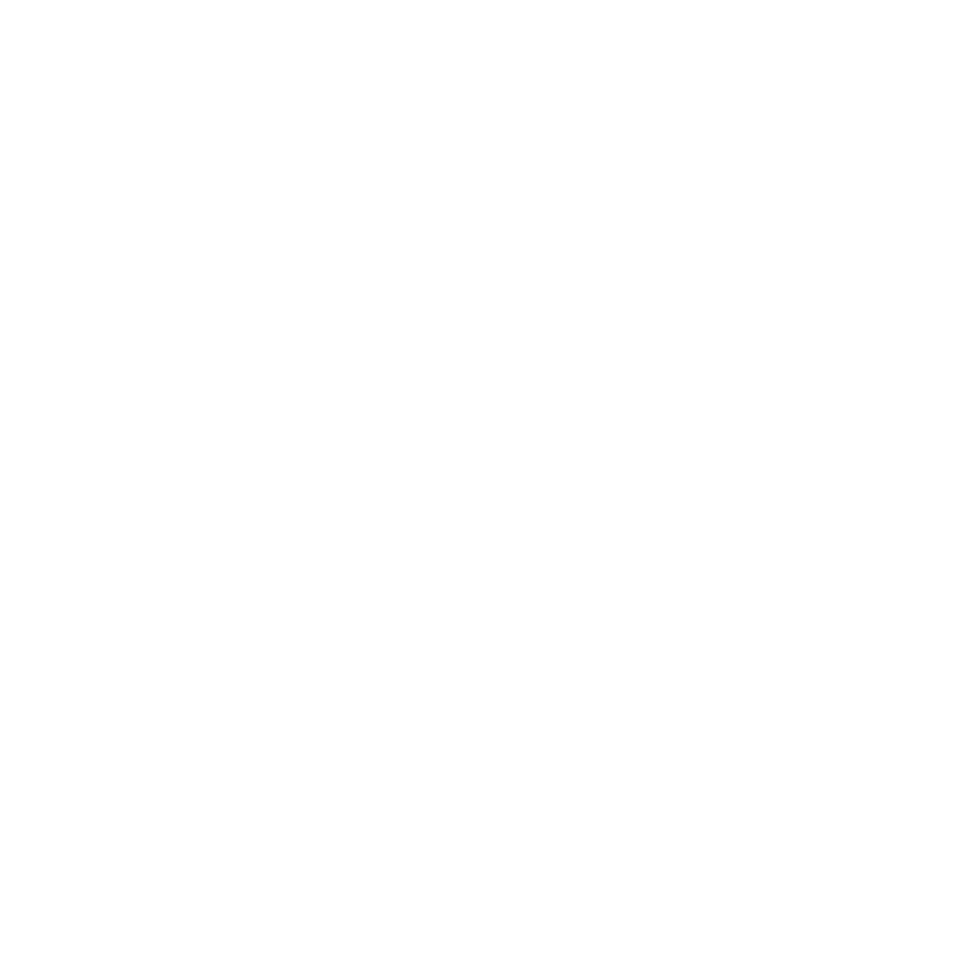

In [1034]:
Tacos['Taco Score'] = (Tacos['Taco Score'] - min(Tacos['Taco Score']))/(max(Tacos['Taco Score']) - min(Tacos['Taco Score']))
GoodTacos = Tacos[Tacos['Taco Score'] > .8]
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(GoodTacos.longitude,GoodTacos.latitude,s=np.exp(5*GoodTacos['Taco Score']),alpha=.5,color='red')
mplleaflet.display(fig=fig)

### The other cool thing we can do is try to find switch points where the distribution parameter changes for reviews. This could be the result of a lot of things - new managment, a new chef, new service. Often times, old reviews of a resturant don't tell us much about what is going on now. Conversely, if a resturant made a recent change, it could be useful for the resturant to monitor whether the change was well or poorly received by the customer base.

### We can use the same methodology to sample from the posterior distribution of the parameters lambda, and introduce a new parameter, t*, which denotes where a possible change in distribution happened.

<IPython.core.display.Javascript object>


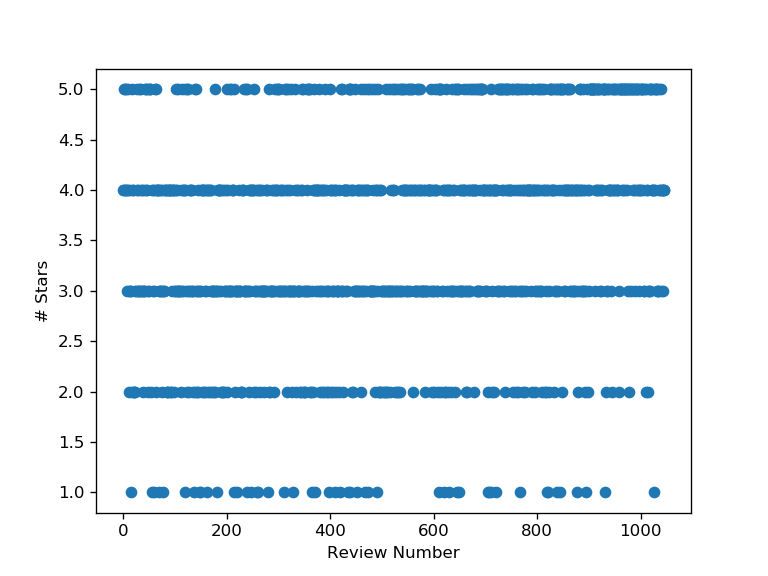

Text(0.5, 0, 'Review Number')

In [1061]:
top_business = Toronto['business_id'].value_counts().head().index.tolist()[3]
stars = Toronto[Toronto['business_id'] == top_business].sort_values('date').stars_y.tolist()
dates = np.linspace(0,len(stars)-1,len(stars))
plt.figure()
plt.plot(dates,stars,'o')
plt.ylabel('# Stars')
plt.xlabel('Review Number')

### By eye, it looks like the reviews got better over time. Can we test this?

In [1064]:
with pm.Model() as test_model:
    # Prior for the time of splitting segment
    tStar1 = pm.Uniform('tStar1',200, 800) #Slightly informative prior
    
    
    # Prior for the probability of lambda in each segment
    lam = pm.Uniform('lam',0,10,shape=2)

   
    grp = (dates > tStar1)*1 
    
    y_obs = pm.Potential('y_obs',likelihood(lam[grp],np.array(stars)-1))

    
with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)
    


Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:11<00:00, 5133.66draws/s]


<IPython.core.display.Javascript object>


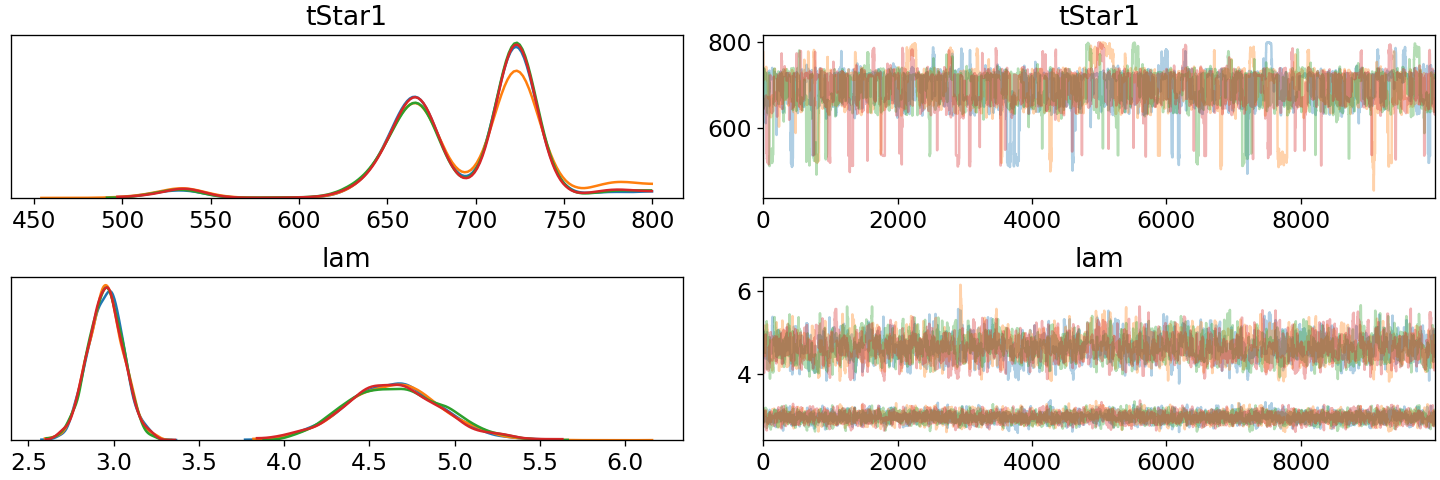

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x27b7c46d8>,
      dtype=object)

In [1065]:
pm.traceplot(trace)

## Multimodal distributions are typical for values of t*, since these reflect discrete events. As we can see, the lambda shifted dramatically after this switch point, and the resturant got better